In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/A Track 학습셋.csv')

중복되는 페이로드들이 발생---> 제거

In [ ]:
# 페이로드와 라벨로 그룹화하여 가장 많이 나타나는 라벨 값 계산
most_common_labels = train_df.groupby('payload')['label_action'].apply(lambda x: x.value_counts().idxmax())

# 원본 데이터프레임을 most_common_labels와 병합하여 라벨 업데이트
train_df['label_action'] = train_df['payload'].map(most_common_labels)

# 중복 제거
train_df = train_df.drop_duplicates(subset=['payload'])

In [ ]:
train_df

,Log_Number,payload,label_action
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution
1,1,POST /owa/auth/logon.aspx?replaceCurrent=1%22%...,System_Cmd_Execution
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection
3,3,GET / HTTP/1.1\r\n\r\n,HOST_Scan
4,4,GET /sub_04_1_read.php?page=1&id=31%29%3BSELEC...,System_Cmd_Execution
...,...,...,...
44993,44993,GET /admin/captcha/securimage_show?160c3e6d29e...,Path_Disclosure
44995,44995,GET /app/javascript/js/skin-responsive.js?v=%3...,System_Cmd_Execution
44996,44996,GET /board/?category=type+%25SYSTEMROOT%25%5Cw...,System_Cmd_Execution
44997,44997,POST /sub_02_4.php HTTP/1.1\r\nContent-Length:...,SQL_Injection


GET / HTTP/1.1\r\n\r\n

In [ ]:
train_df['payload'].iloc[3]

'GET / HTTP/1.1\\r\\n\\r\\n'

In [ ]:
matching_indices = train_df[train_df['payload'] == 'GET / HTTP/1.1\r\n\r\n'].index.tolist()

In [ ]:
matching_indices

[]

# 1. 시각화

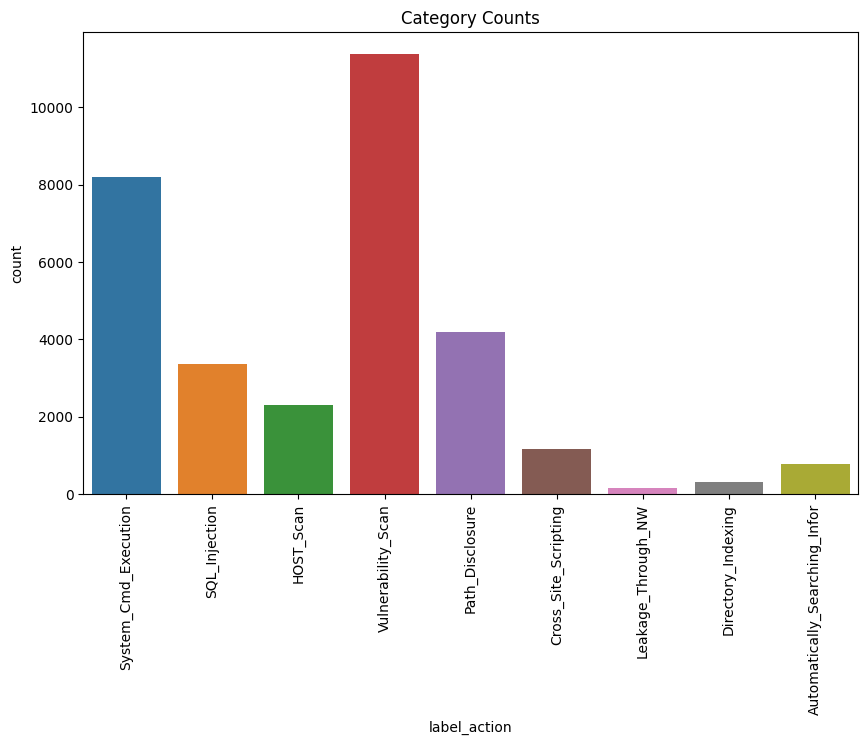

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=train_df)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()



#2. 인코딩
디코딩이 된 url을 인코딩해서 길이를 줄이자.

In [ ]:
train_df

,Log_Number,payload,label_action
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution
1,1,POST /owa/auth/logon.aspx?replaceCurrent=1%22%...,System_Cmd_Execution
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection
3,3,GET / HTTP/1.1\r\n\r\n,HOST_Scan
4,4,GET /sub_04_1_read.php?page=1&id=31%29%3BSELEC...,System_Cmd_Execution
...,...,...,...
44993,44993,GET /admin/captcha/securimage_show?160c3e6d29e...,Path_Disclosure
44995,44995,GET /app/javascript/js/skin-responsive.js?v=%3...,System_Cmd_Execution
44996,44996,GET /board/?category=type+%25SYSTEMROOT%25%5Cw...,System_Cmd_Execution
44997,44997,POST /sub_02_4.php HTTP/1.1\r\nContent-Length:...,SQL_Injection


In [ ]:
decode_average_length = train_df['payload'].apply(len).mean()
print("인코딩 전:",decode_average_length)

인코딩 전: 648.3461937227057


In [ ]:
import urllib.parse

for i in range(31829):
  try:
    text = train_df['payload'].iloc[i]
    train_df['payload'].iloc[i] = urllib.parse.unquote_plus(text)
  except:
    pass

<ipython-input-12-b5dc79657589>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['payload'].iloc[i] = urllib.parse.unquote_plus(text)


In [ ]:
incode_average_length = train_df['payload'].apply(len).mean()
print("인코딩 전:",decode_average_length)
print("인코딩 후:",incode_average_length)

인코딩 전: 648.3461937227057
인코딩 후: 590.7042319896949


# 3. 해더를 구분하기

아래의 예시를 보면 알 수 있듯 공격 패턴을 식별할 수 있는 것 이외에 불필요한 정보들이 너무 많다.

일단 정보를 구분해보자.

In [ ]:
import urllib.parse

for i in range(31829):

    text = train_df['payload'].iloc[i]
    text_1 = text.split('\\r\\n')
    if len(text_1) == 1:
      text_1 = text.split('\r\n')
      train_df['payload'].iloc[i] = text_1
    else:
      train_df['payload'].iloc[i] = text_1
    if len(text_1) == 1:
      text_1 = text.split('\\n')
      train_df['payload'].iloc[i] = text_1
    else:
      train_df['payload'].iloc[i] = text_1
    if len(text_1) == 1:
      text_1 = text.split('\\u')
      train_df['payload'].iloc[i] = text_1
    else:
      train_df['payload'].iloc[i] = text_1

<ipython-input-14-5b6bead276fd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['payload'].iloc[i] = text_1
<ipython-input-14-5b6bead276fd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['payload'].iloc[i] = text_1
<ipython-input-14-5b6bead276fd>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['payload'].iloc[i] = text_1
<ipython-input-14-5b6bead276fd>:9: SettingWithCopyWarning: 
A value is trying to b

In [ ]:
for i in range(31829):
  if len(train_df['payload'].iloc[i]) == 1:
    print(i)

In [ ]:
train_df['payload'].iloc[1001]

['POST /member/login HTTP/1.1',
 'Content-Length: 53',
 'Cache-Control: no-cache',
 'User-Agent: sqlmap/1.6.10#stable (https://sqlmap.org)',
 'Referer: -3712\\") OR 5520=UTL_INADDR.GET_HOST_ADDRESS(CHR(113)||CHR(107)||CHR(113)||CHR(122)||CHR(113)||(SELECT (CASE WHEN (5520=5520) THEN 1 ELSE 0 END) FROM DUAL)||CHR(113)||CHR(98)||CHR(122)||CHR(107)||CHR(113)) AND (\\"EWZB\\" LIKE \\"EWZB',
 'Host: 10.0.17.19',
 'Cookie: designart_site=i5vk3uu5a7vdk01er6d636fpq9mklecb',
 'Accept: */*',
 'Accept-Encoding: gzip,deflate',
 'Content-Type: application/x-www-form-urlencoded; charset=utf-8',
 'Connection: close',
 '',
 'encrypt=p2&return_url=&userid=admin&password=password']

In [ ]:
train_df['payload'].iloc[101]

['GET /goods/goods_search?display_type=list&arr_search_list[0][search_type]=Gm.name&arr_search_list[0][search]=1&search_include=file:///../../../../../windows/win.ini............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................&search=1&search_type=Gm.name HTTP/1.1',
 'Host: www.college.school',
 'Authorization: Negotiate TlRMTVNTUAABAAAAt4II4gAAAAAAAAAAAAAAA

In [ ]:
train_df['payload'].iloc[11]

['POST /controller/login.php HTTP/1.1',
 'Content-Length: 239',
 'Cache-Control: no-cache',
 'User-Agent: sqlmap/1.6.7#stable (https://sqlmap.org)',
 'Cookie: PHPSESSID=8ndjmp9vjimv0n3ppkhi1mh9ln',
 'Host: 10.0.17.20',
 'Accept: */*',
 'Accept-Encoding: gzip,deflate',
 'Content-Type: application/x-www-form-urlencoded; charset=utf-8',
 'Connection: close',
 '',
 "type=login&userid=admin' AND ORD(MID((SELECT IFNULL(CAST(user_password AS NCHAR),0x20) FROM college.members ORDER BY id LIMIT 6,1),61,1))>96 AND 'wJAh'='wJAh&password=123456"]

In [ ]:
train_df['payload'].iloc[3281]

['GET /goods/goods_search?display_type=/../windows/win.ini\x00.&search_include=y&search=1&search_type=Gm.name HTTP/1.1',
 'Host: www.college.school',
 'Authorization: Negotiate TlRMTVNTUAABAAAAt4II4gAAAAAAAAAAAAAAAAAAAAAKAF1YAAAADw==',
 'Accept-Encoding: gzip, deflate',
 'User-Agent: Mozilla/5.0 (Gecko) Arachni/v10.0.0.80',
 'Accept: text/html,application/xhtml xml,application/xml;q=0.9,*/*;q=0.8',
 'Accept-Language: en-US,en;q=0.8,he;q=0.6',
 'X-Arachni-Scan-Seed: 4818b1cc56353e785f9bfe9b055b7183',
 'Cookie: designart_site=cg0q4hq5j1rgo9o2ns7s3nsnjlauq1rp',
 '',
 '']

In [ ]:
train_df['payload'].iloc[3181]

['GET /s/3333e293e2830313e2031323/_/;/META-INF/maven/com.atlassian.jira/jira-webapp-dist/pom.properties HTTP/1.1',
 'Host: 10.0.17.27',
 'User-Agent: Go-http-client/1.1',
 'Accept-Encoding: gzip',
 'Connection: close',
 '',
 '']

# 4. 쓸만한 데이터와 불필요한 데이터 구분

쓸만한 헤더----> 특정 카테고리에만 사용하는 해더. 즉 구분할 수 있어야 한다.

그리고 지금 데이터의 분포가 유의미한 것들을 분류할 수 있어야 한다.

그리고 통상 SQL문이나 기타 등등 맨 앞 payload 메서드 부분은 항상 중요하다.

그리고 맨 마지막 부분도 역시 항상 중요하다. 구분에 꼭 필요하다..

즉 나머지 해더에 대해서 분포가 유의미한 라벨 값을 분류할 수 있어야 한다.

근데 이왕이면 최소한의 첫번째 메서드 값과 마지막 값만 유지하고 싶다.---> 연산량을 최소화 하기 위해서

 따라서 일단 모델을 만들어 보고 성능을 높이는 방법으로 헤더들을 추가하는

 방향으로 잡자.

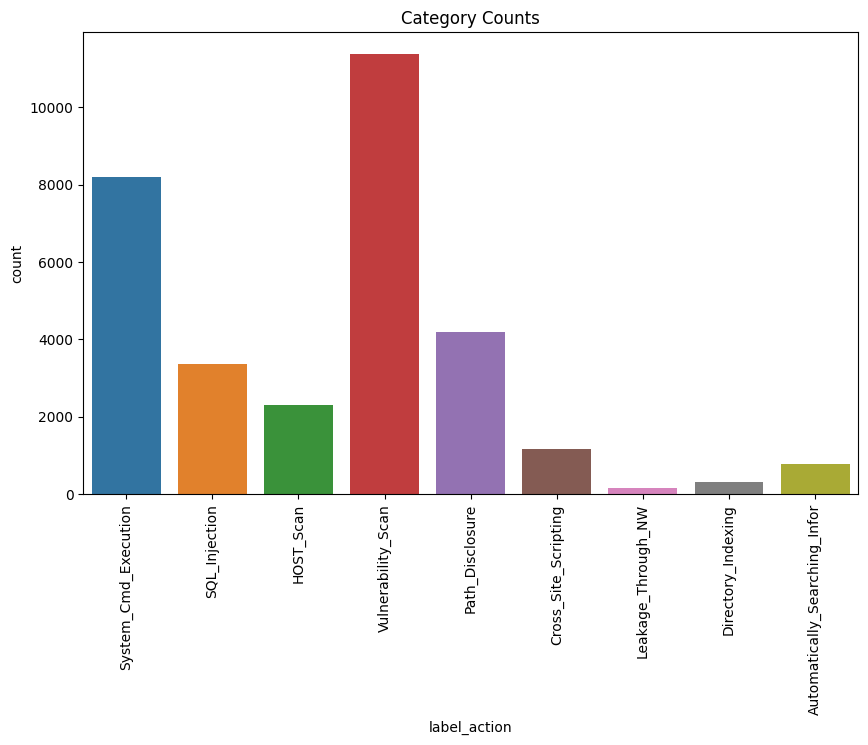

In [ ]:
train1_df = pd.read_csv('/content/gdrive/MyDrive/A Track 학습셋.csv')

Go-http-client

## encrypt

In [ ]:
# 페이로드와 라벨로 그룹화하여 가장 많이 나타나는 라벨 값 계산
most_common_labels = train1_df.groupby('payload')['label_action'].apply(lambda x: x.value_counts().idxmax())

# 원본 데이터프레임을 most_common_labels와 병합하여 라벨 업데이트
train1_df['label_action'] = train1_df['payload'].map(most_common_labels)

# 중복 제거
train1_df = train1_df.drop_duplicates(subset=['payload'])

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('encrypt', na=False)]


In [ ]:
filtered_data['payload'].iloc[31]

'POST /member/login HTTP/1.0\\r\\nHost: 10.0.17.19\\r\\nUser-Agent: Mozilla/5.0 (Hydra)\\r\\nContent-Length: 51\\r\\nContent-Type: application/x-www-form-urlencoded\\r\\nCookie: designart_site=d07tf95i6g87rdk5m8s7jdhcl1vusqje\\r\\n\\r\\nencrypt=p2&return_url=&userid=test2&password=window'

In [ ]:
filtered_data['payload'].iloc[11]

'POST /member/login HTTP/1.1\\r\\nContent-Length: 53\\r\\nCache-Control: no-cache\\r\\nUser-Agent: sqlmap/1.6.10#stable (https://sqlmap.org)\\r\\nReferer: -3712\\") OR 5520=UTL_INADDR.GET_HOST_ADDRESS(CHR(113)||CHR(107)||CHR(113)||CHR(122)||CHR(113)||(SELECT (CASE WHEN (5520=5520) THEN 1 ELSE 0 END) FROM DUAL)||CHR(113)||CHR(98)||CHR(122)||CHR(107)||CHR(113)) AND (\\"EWZB\\" LIKE \\"EWZB\\r\\nHost: 10.0.17.19\\r\\nCookie: designart_site=i5vk3uu5a7vdk01er6d636fpq9mklecb\\r\\nAccept: */*\\r\\nAccept-Encoding: gzip,deflate\\r\\nContent-Type: application/x-www-form-urlencoded; charset=utf-8\\r\\nConnection: close\\r\\n\\r\\nencrypt=p2&return_url=&userid=admin&password=password'

In [ ]:
filtered_data

,Log_Number,payload,label_action
404,404,POST /member/login HTTP/1.1\r\nContent-Length:...,SQL_Injection
425,425,POST /member/login HTTP/1.0\r\nHost: 10.0.17.1...,Vulnerability_Scan
679,679,POST /member/login HTTP/1.0\r\nHost: 10.0.17.1...,Vulnerability_Scan
854,854,POST /member/login HTTP/1.1\r\nContent-Length:...,SQL_Injection
858,858,POST /member/login HTTP/1.0\r\nHost: 10.0.17.1...,Vulnerability_Scan
...,...,...,...
44681,44681,POST /member/login HTTP/1.0\r\nHost: 10.0.17.1...,Vulnerability_Scan
44755,44755,POST /member/login HTTP/1.0\r\nHost: 10.0.17.1...,Vulnerability_Scan
44892,44892,POST /member/login HTTP/1.0\r\nHost: 10.0.17.1...,Vulnerability_Scan
44915,44915,POST /member/login HTTP/1.1\r\nContent-Length:...,SQL_Injection


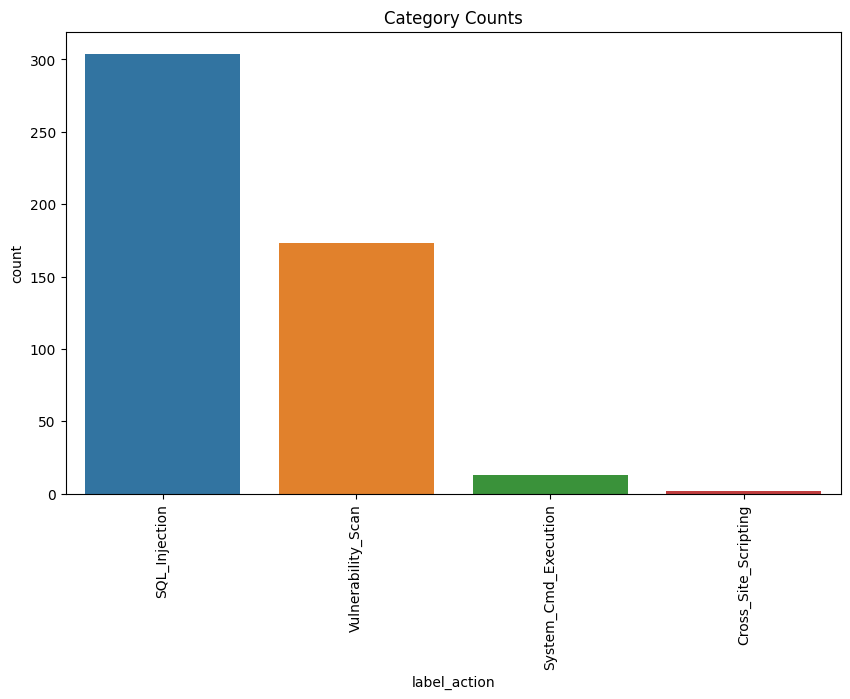

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

sql과 vu에만 많이 사용되고 나머지 카테고리는 사용되지 않으므로 분류에 사용할 수 있다. 하지만 마지막 부분에 적용되는 부분이다.---> 즉 따로 처리할 필요 없다.

## Content-Length

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Content-Length', na=False)]
filtered_data

,Log_Number,payload,label_action
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution
1,1,POST /owa/auth/logon.aspx?replaceCurrent=1%22%...,System_Cmd_Execution
5,5,POST /member/login HTTP/1.1\r\nContent-Length:...,Vulnerability_Scan
6,6,GET /board/?category=&gdviewer=1&goods_seq=69&...,System_Cmd_Execution
8,8,GET /vendor/phpunit/phpunit/src/Util/PHP/eval-...,HOST_Scan
...,...,...,...
44992,44992,POST /member/login HTTP/1.1\r\nContent-Length:...,SQL_Injection
44993,44993,GET /admin/captcha/securimage_show?160c3e6d29e...,Path_Disclosure
44995,44995,GET /app/javascript/js/skin-responsive.js?v=%3...,System_Cmd_Execution
44996,44996,GET /board/?category=type+%25SYSTEMROOT%25%5Cw...,System_Cmd_Execution


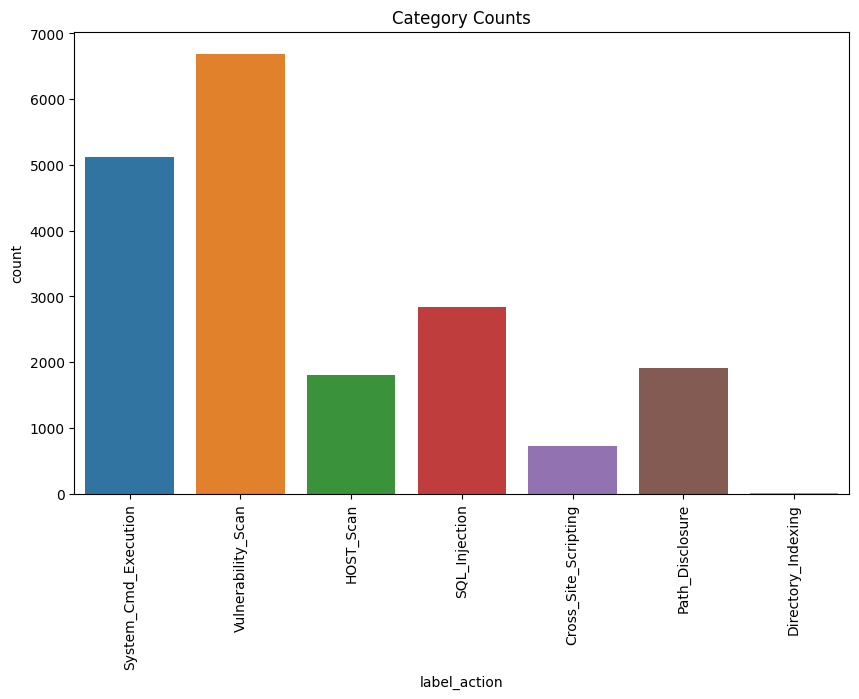

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

## Cache-Control

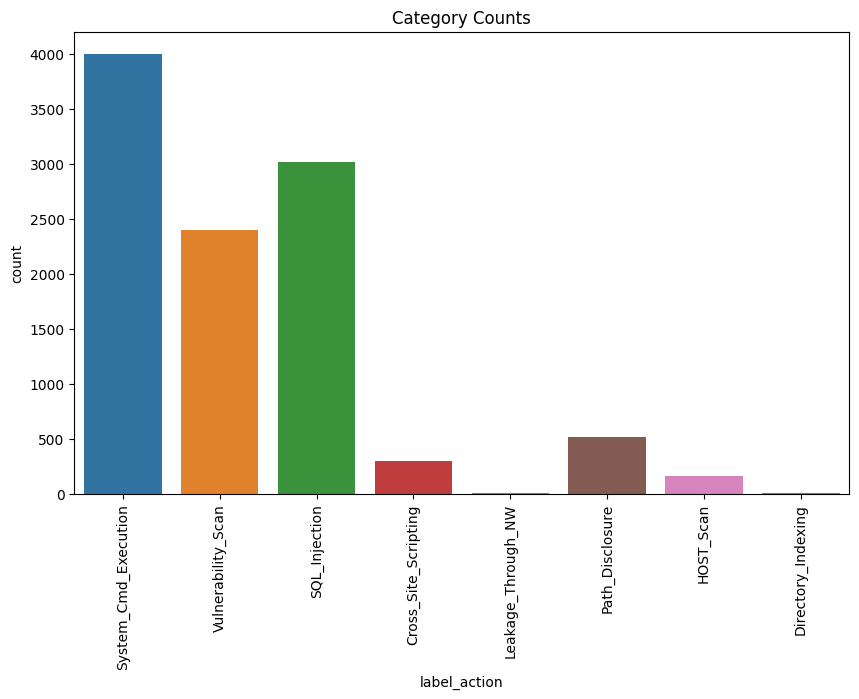

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Cache-Control', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

순서가 system_cmd, vul, sql이므로 특징이라고 볼 수 있겠다.

## Cookie

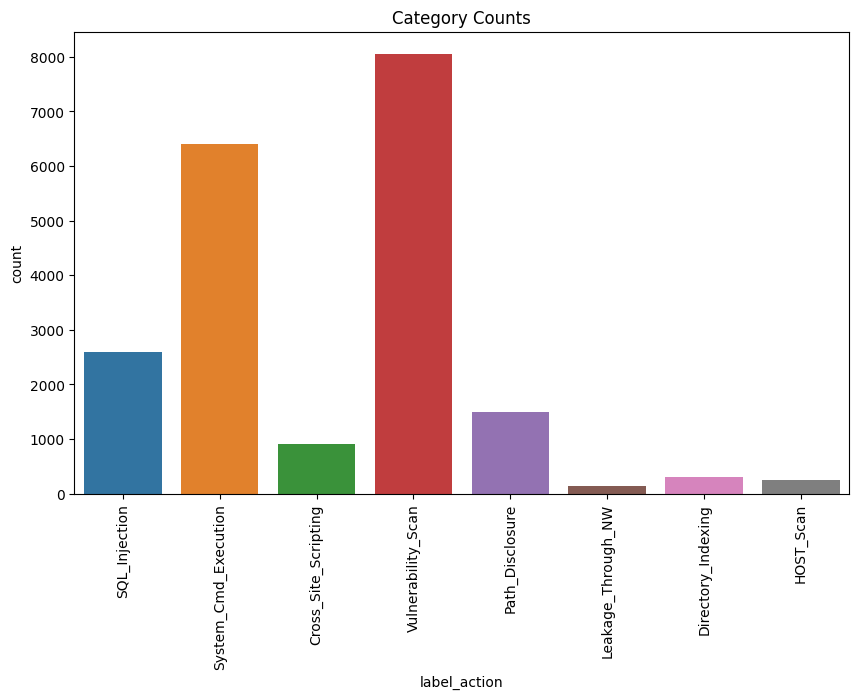

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Cookie', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

## Accept

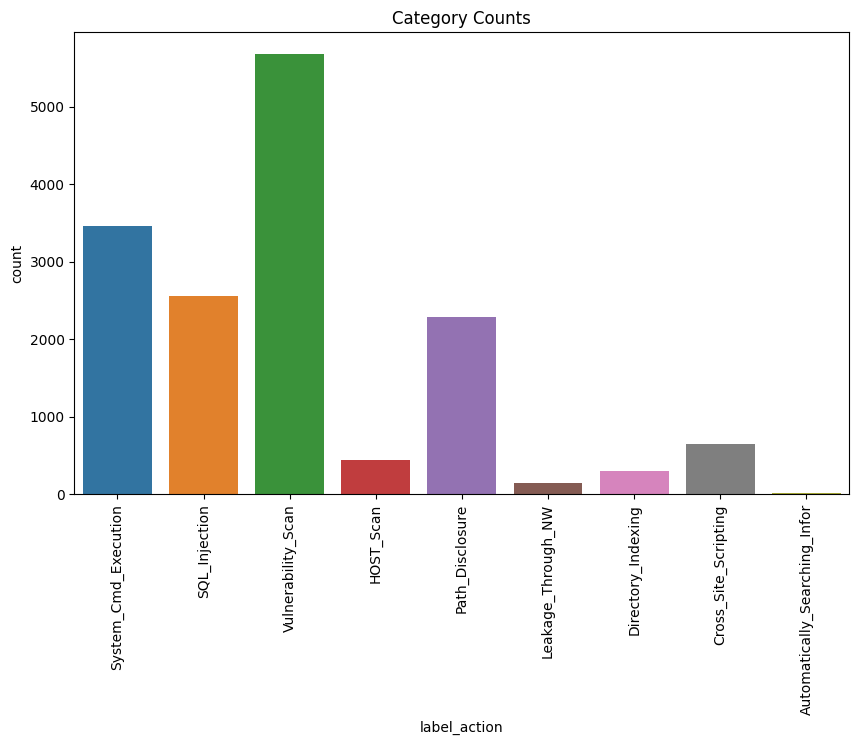

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Accept', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

## Accept-Encoding

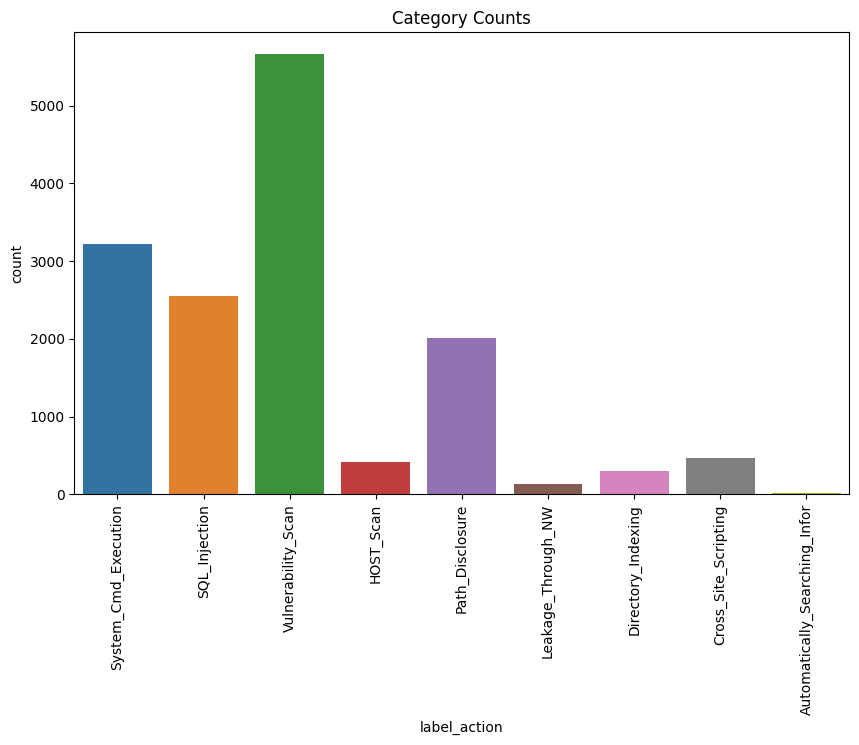

In [ ]:

import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Accept-Encoding', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

##Content-Type

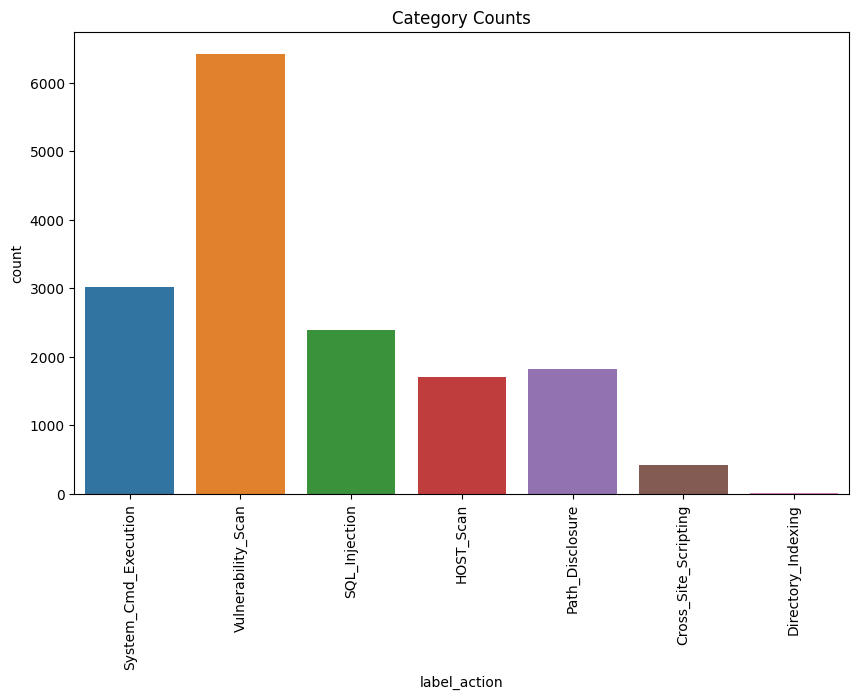

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Content-Type', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

## Connection

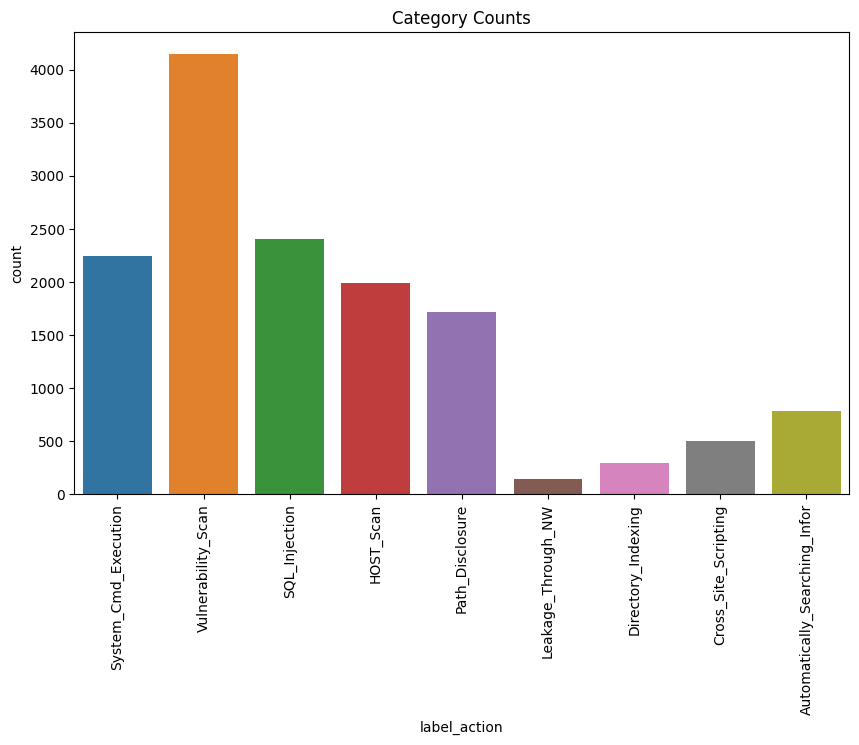

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Connection', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

attention을 분류하기 위해 사용할 수 있을듯?

## Referer

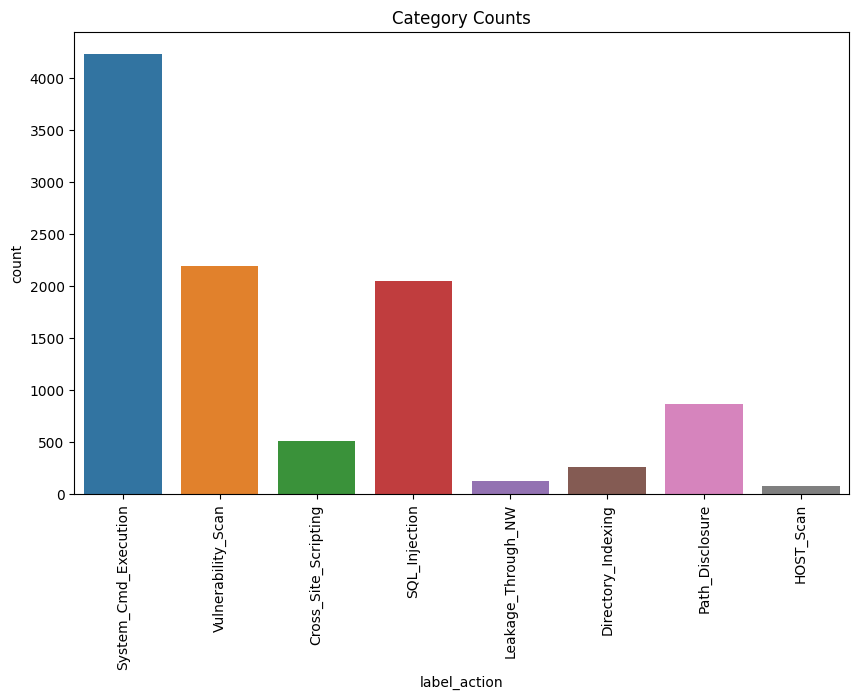

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Referer', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

이친구고 1등 순서가 좀 압도적으로 차이가 남. 구분이 가능할 듯.

## X-Arachni-Scan-Seed

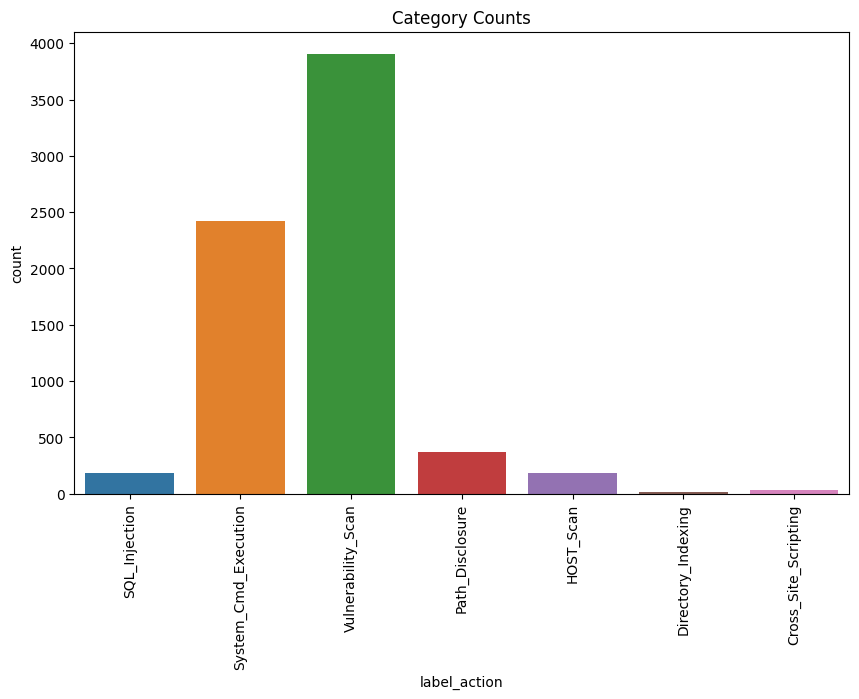

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('X-Arachni-Scan-Seed', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

## Accept-Language

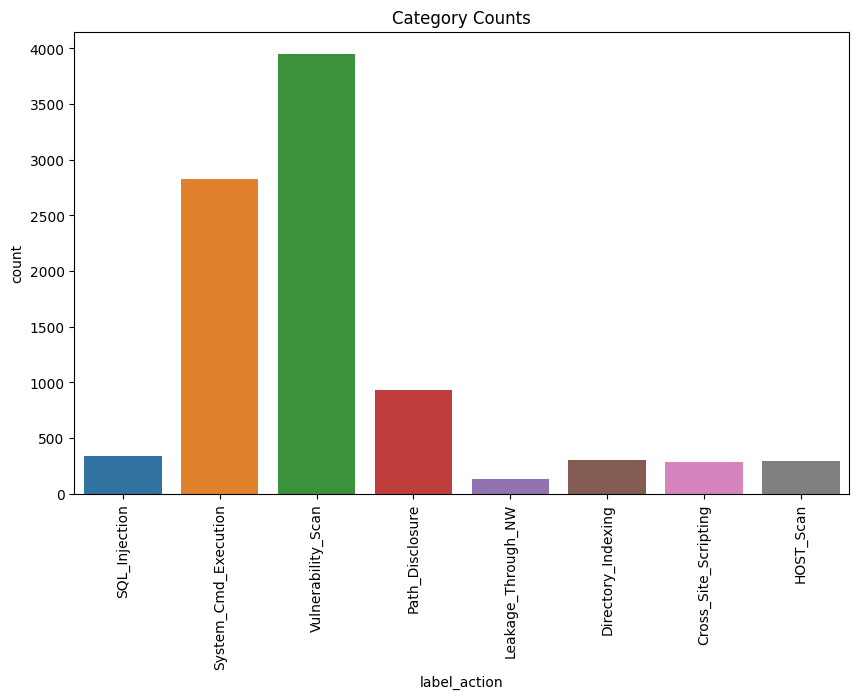

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Accept-Language', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

## Authorization

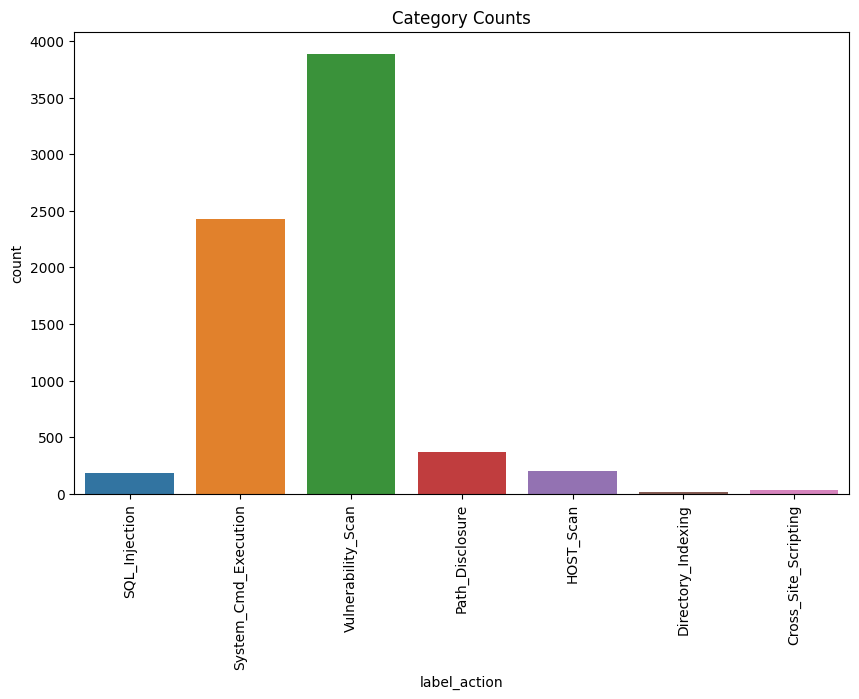

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Authorization', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

## Pragma

In [ ]:
filtered_data['payload'].iloc[3181]

'POST /controller/board.php HTTP/1.1\\r\\nHost: lab.college.school\\r\\nAuthorization: Negotiate TlRMTVNTUAABAAAAt4II4gAAAAAAAAAAAAAAAAAAAAAKAF1YAAAADw==\\r\\nAccept-Encoding: gzip, deflate\\r\\nUser-Agent: Mozilla/5.0 (Gecko) Arachni/v10.0.0.80\\r\\nAccept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8\\r\\nAccept-Language: en-US,en;q=0.8,he;q=0.6\\r\\nX-Arachni-Scan-Seed: 4d6dcba752fbf256edf9136809ab9888\\r\\nCookie: PHPSESSID=qelpc94one7qlgbv5nm3mu0oet\\r\\nContent-Length: 741\\r\\nContent-Type: application/x-www-form-urlencoded\\r\\n\\r\\ntype=getAbout&id=%2Fwindows%2Fwin.ini............................................................................................................................................................................................................................................................................................................................................................................................................

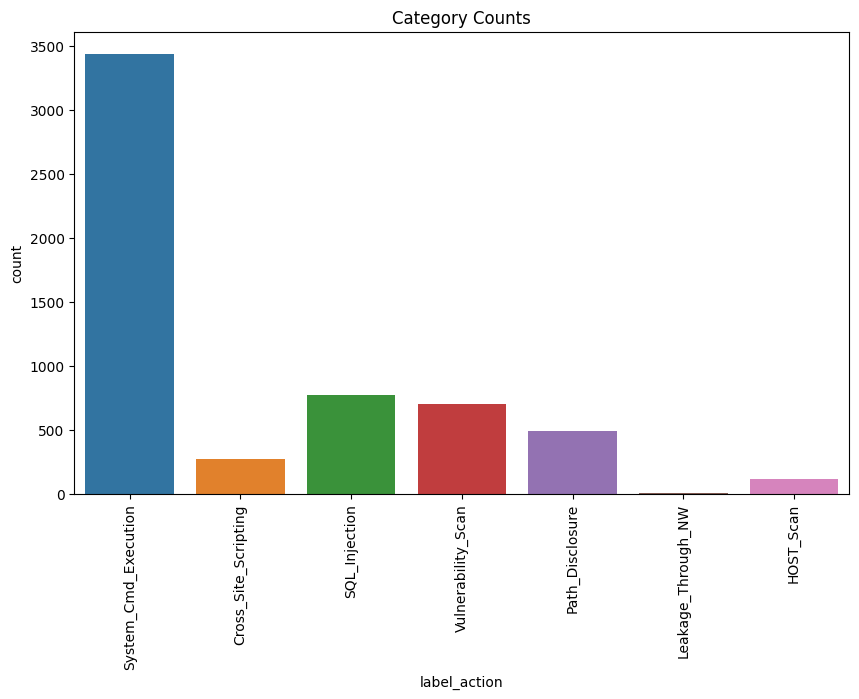

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Pragma', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

## Expect

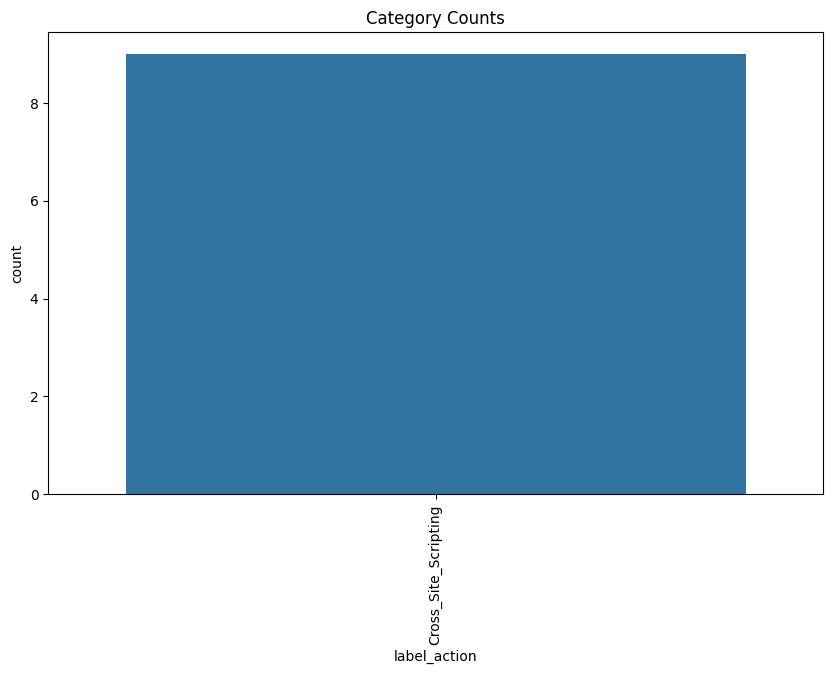

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Expect', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

이것도 쓰면 좋을듯?

## From

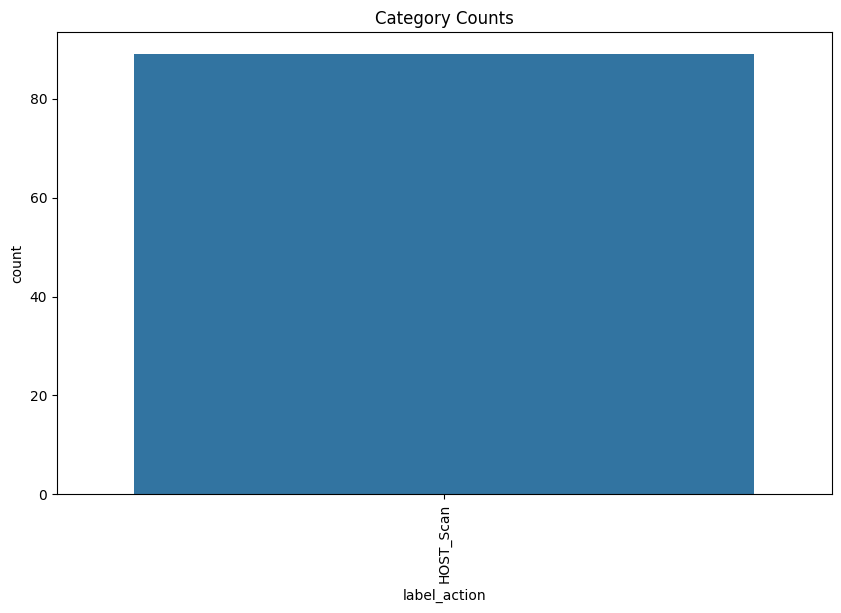

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('From', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

In [ ]:
filtered_data['payload'].iloc[3]

'GET /app/javascript/js/echo.js?_=1666571057226 HTTP/1.1\\r\\nCache-Control: no-cache\\r\\nConnection: Keep-Alive\\r\\nPragma: no-cache\\r\\nAccept: */*\\r\\nAccept-Encoding: \\r\\nFrom: bingbot(at)microsoft.com\\r\\nHost: www.mall.shop\\r\\nUser-Agent: Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/534+ (KHTML, like Gecko) BingPreview/1.0b\\r\\n\\r\\n'

이것도 쓰면 좋을듯?

## TE

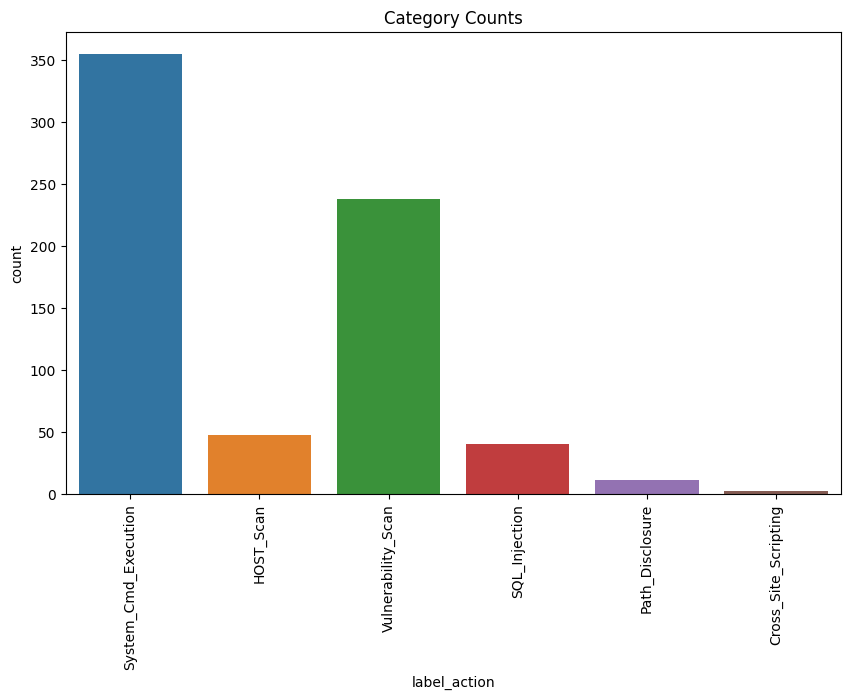

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('TE', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

의미x

## If-None-Match

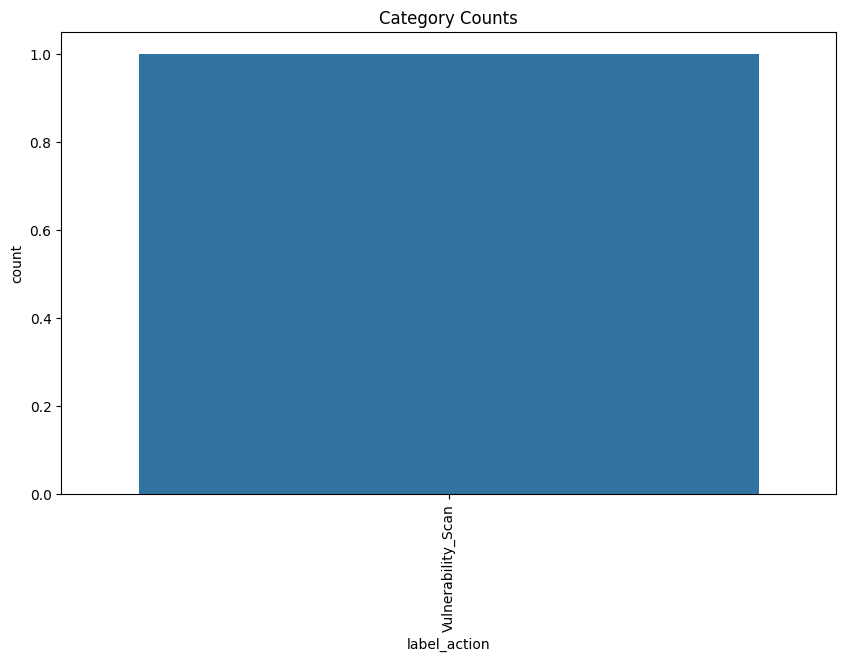

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('If-None-Match', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

## Proxy-Authorization

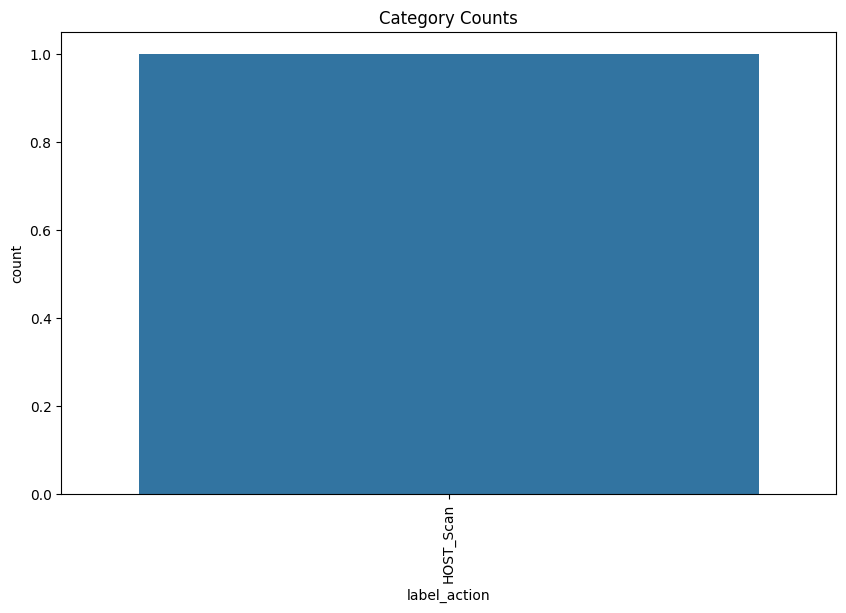

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Proxy-Authorization', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

## Upgrade

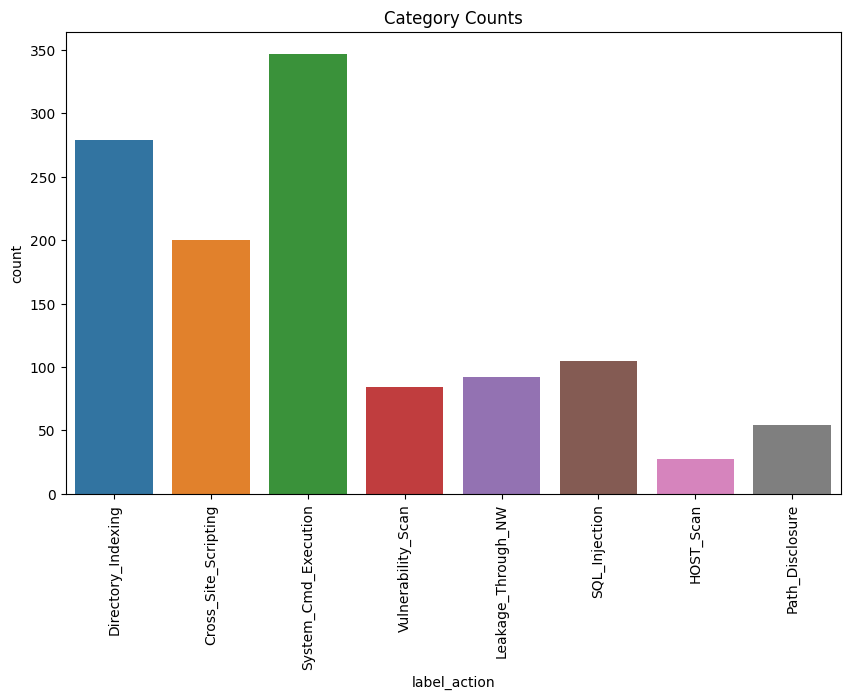

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Upgrade', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

이거는 쓰면 좋을듯?

## If-Modified-Since

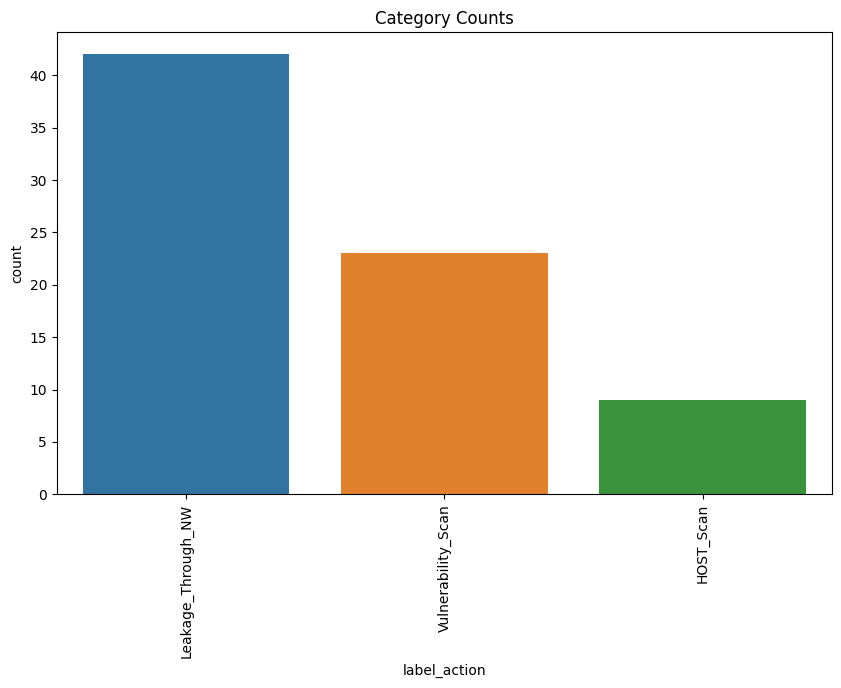

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('If-Modified-Since', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

If-Modified-Since 이것도 쓰면 좋을듯?

## Accept-Charset

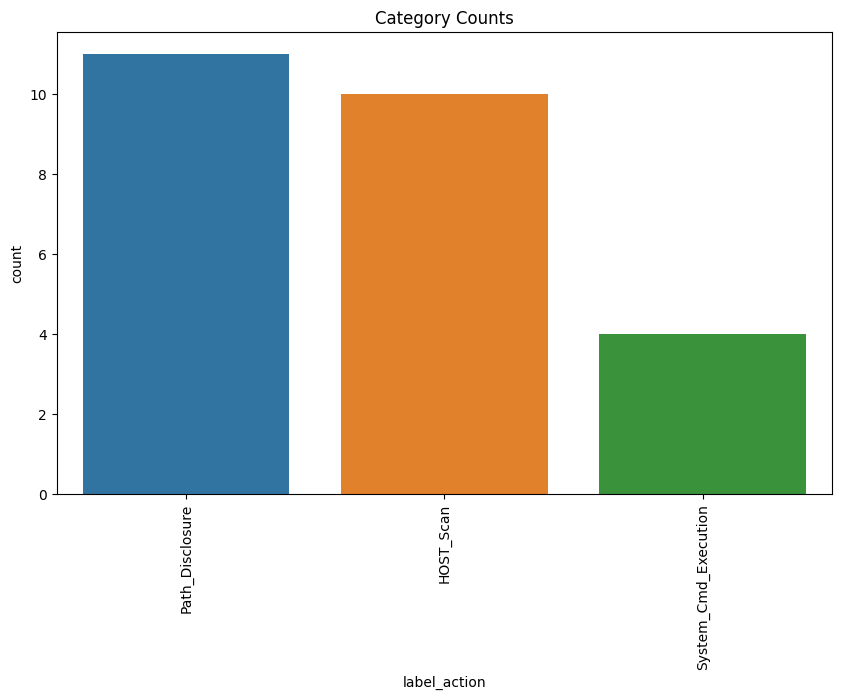

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('Accept-Charset', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

Accept-Charset 사용 가능

In [ ]:
filtered_data['payload'].iloc[1]

'GET /static../.git/config HTTP/1.1\\r\\nHost: 10.0.17.24:443\\r\\nUser-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15\\r\\nAccept-Charset: utf-8\\r\\nAccept-Encoding: gzip\\r\\nConnection: close\\r\\n\\r\\n'

## If-Range

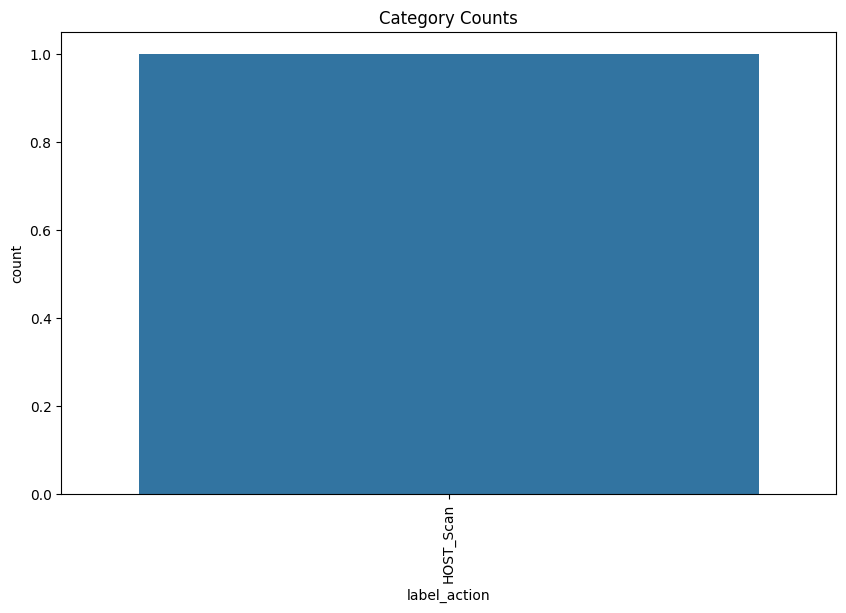

In [ ]:
import pandas as pd


# Filter the data where the 'payload' column contains the string 'X-Arachni-Scan-Seed'
filtered_data = train1_df[train1_df['payload'].str.contains('If-Range', na=False)]
filtered_data

import seaborn as sns
import matplotlib.pyplot as plt

# 그림 크기 설정
plt.figure(figsize=(10,6))

sns.countplot(x='label_action', data=filtered_data)
plt.title('Category Counts')

# X 축 레이블의 글자를 45도로 회전
plt.xticks(rotation=90)

plt.show()

# 5.헤더를 제거해보자.

In [ ]:
train_df

,Log_Number,payload,label_action
0,0,"[GET /forum1_professionnel.asp?n=/.\\\""./.\\\""...",System_Cmd_Execution
1,1,"[POST /owa/auth/logon.aspx?replaceCurrent=1"") ...",System_Cmd_Execution
2,2,[GET /goods/goods_search?display_type=list&arr...,SQL_Injection
3,3,"[GET / HTTP/1.1, , ]",HOST_Scan
4,4,[GET /sub_04_1_read.php?page=1&id=31);SELECT *...,System_Cmd_Execution
...,...,...,...
44993,44993,[GET /admin/captcha/securimage_show?160c3e6d29...,Path_Disclosure
44995,44995,[GET /app/javascript/js/skin-responsive.js?v=;...,System_Cmd_Execution
44996,44996,[GET /board/?category=type %SYSTEMROOT%\win.in...,System_Cmd_Execution
44997,44997,"[POST /sub_02_4.php HTTP/1.1, Content-Length: ...",SQL_Injection


In [ ]:
train_df['payload'].iloc[1]

['POST /owa/auth/logon.aspx?replaceCurrent=1") AND 9294=UTL_INADDR.GET_HOST_ADDRESS(CHR(113)||CHR(112)||CHR(98)||CHR(120)||CHR(113)||(SELECT (CASE WHEN (9294=9294) THEN 1 ELSE 0 END) FROM DUAL)||CHR(113)||CHR(122)||CHR(106)||CHR(107)||CHR(113)) AND ("tdDX"="tdDX&reason=3&url= HTTP/1.1',
 'Content-Length: 0',
 'Cache-Control: no-cache',
 'User-Agent: sqlmap/1.6.7#stable (https://sqlmap.org)',
 'Referer: http://owa.college.school:80/owa/auth/logon.aspx',
 'Host: owa.college.school',
 'Accept: */*',
 'Accept-Encoding: gzip,deflate',
 'Content-Type: application/x-www-form-urlencoded; charset=utf-8',
 'Connection: close',
 '',
 '']

In [ ]:
import pandas as pd

# 가정: train_df는 이미 로드된 DataFrame이며, 각 'payload' 값은 줄바꿈을 기준으로 분할된 리스트입니다.
for i in range(len(train_df)):
    payload = train_df['payload'].iloc[i]

    # 리스트의 첫 번째와 마지막 값을 \n를 이용해서 합치기
    combined_text = f"{payload[0]}\n{payload[-1]}"

    # DataFrame에 저장
    train_df['payload'].iloc[i] = combined_text


<ipython-input-55-62e7dece5b58>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['payload'].iloc[i] = combined_text


In [ ]:
train_df['payload'].iloc[1]

'POST /owa/auth/logon.aspx?replaceCurrent=1") AND 9294=UTL_INADDR.GET_HOST_ADDRESS(CHR(113)||CHR(112)||CHR(98)||CHR(120)||CHR(113)||(SELECT (CASE WHEN (9294=9294) THEN 1 ELSE 0 END) FROM DUAL)||CHR(113)||CHR(122)||CHR(106)||CHR(107)||CHR(113)) AND ("tdDX"="tdDX&reason=3&url= HTTP/1.1\n'

In [ ]:
train_df

,Log_Number,payload,label_action
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution
1,1,"POST /owa/auth/logon.aspx?replaceCurrent=1"") A...",System_Cmd_Execution
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection
3,3,GET / HTTP/1.1\n,HOST_Scan
4,4,GET /sub_04_1_read.php?page=1&id=31);SELECT * ...,System_Cmd_Execution
...,...,...,...
44993,44993,GET /admin/captcha/securimage_show?160c3e6d29e...,Path_Disclosure
44995,44995,GET /app/javascript/js/skin-responsive.js?v=; ...,System_Cmd_Execution
44996,44996,GET /board/?category=type %SYSTEMROOT%\win.ini...,System_Cmd_Execution
44997,44997,POST /sub_02_4.php HTTP/1.1\ntype=getSub0204Li...,SQL_Injection


In [ ]:
# for i in range(31829):

#     text = '\\n'.join([train_df['payload'].iloc[i][0], train_df['payload'].iloc[i][-1]])
#     train_df['payload'].iloc[i] = text

In [ ]:
train_df['payload'].iloc[1]

'POST /owa/auth/logon.aspx?replaceCurrent=1") AND 9294=UTL_INADDR.GET_HOST_ADDRESS(CHR(113)||CHR(112)||CHR(98)||CHR(120)||CHR(113)||(SELECT (CASE WHEN (9294=9294) THEN 1 ELSE 0 END) FROM DUAL)||CHR(113)||CHR(122)||CHR(106)||CHR(107)||CHR(113)) AND ("tdDX"="tdDX&reason=3&url= HTTP/1.1\n'

In [ ]:
train_df['payload'].iloc[700]

'POST /admin/login.php HTTP/1.0\nuserid=admin&password=58787'

In [ ]:
train_df['payload'].iloc[3181]

'GET /s/3333e293e2830313e2031323/_/;/META-INF/maven/com.atlassian.jira/jira-webapp-dist/pom.properties HTTP/1.1\n'

In [ ]:
train_df['payload'].iloc[318]

'GET /goods/goods_search?display_type=list&arr_search_list[0][search_type]=Gm.name&arr_search_list[0][search]=1&arr_search_list[1][search_type]=Gm.name&arr_search_list[1][search]=1&arr_search_list[2][search_type]=Gm.name&arr_search_list[2][search]=1&arr_search_list[3][search_type]=Gm.name&arr_search_list[3][search]=1&arr_search_list[4][search_type]=Gm.name&arr_search_list[4][search]=1&arr_search_list[5][search_type]=Gm.name&arr_search_list[5][search]=1&arr_search_list[6][search_type]=Gm.name&arr_search_list[6][search]=1&arr_search_list[7][search_type]=Gm.name&arr_search_list[7][search]=1&arr_search_list[8][search_type]=Gm.name&arr_search_list[8][search]=1&arr_search_list[9][search_type]=Gm.name&arr_search_list[9][search]=1&search_include=y&search=file:///../../windows/win.ini&search_type=Gm.name HTTP/1.1\n'

In [ ]:
average_length = train_df['payload'].apply(len).mean()
print(average_length)

253.2120707530868


# 6-1. 제거해야 하는 패턴 "search_list".
GET /goods/goods_search?display_type=list&arr_search_list[0][search_type]=Gm.name&arr_search_list[0][search]=1&arr_search_list[1][search_type]=Gm.name&arr_search_list[1][search]=1&arr_search_list[2][search_type]=Gm.name&arr_search_list[2][search]=1&arr_search_list[3][search_type]=Gm.name&arr_search_list[3][search]=1&arr_search_list[4][search_type]=Gm.name&arr_search_list[4][search]=1&arr_search_list[5][search_type]=Gm.name&arr_search_list[5][search]=1&arr_search_list[6][search_type]=Gm.name&arr_search_list[6][search]=1&arr_search_list[7][search_type]=Gm.name&arr_search_list[7][search]=1&arr_search_list[8][search_type]=Gm.name&arr_search_list[8][search]=1&arr_search_list[9][search_type]=Gm.name&arr_search_list[9][search]=1&search_include=y&search=file:///../../windows/win.ini&search_type=Gm.name HTTP/1.1\n

위는 318번 데이터다. 이런 반복해서 나오는 패턴은 공격 분석에 하등 불필요하므로 지워야 한다.

In [ ]:
train_df['payload'].iloc[318]

'GET /goods/goods_search?display_type=list&arr_search_list[0][search_type]=Gm.name&arr_search_list[0][search]=1&arr_search_list[1][search_type]=Gm.name&arr_search_list[1][search]=1&arr_search_list[2][search_type]=Gm.name&arr_search_list[2][search]=1&arr_search_list[3][search_type]=Gm.name&arr_search_list[3][search]=1&arr_search_list[4][search_type]=Gm.name&arr_search_list[4][search]=1&arr_search_list[5][search_type]=Gm.name&arr_search_list[5][search]=1&arr_search_list[6][search_type]=Gm.name&arr_search_list[6][search]=1&arr_search_list[7][search_type]=Gm.name&arr_search_list[7][search]=1&arr_search_list[8][search_type]=Gm.name&arr_search_list[8][search]=1&arr_search_list[9][search_type]=Gm.name&arr_search_list[9][search]=1&search_include=y&search=file:///../../windows/win.ini&search_type=Gm.name HTTP/1.1\n'

In [ ]:
import urllib.parse
import re

for i in range(31829):
  try:
    train_df['payload'].iloc[i] = re.sub(r"&arr_search_list\[\d+\]\[search_type\]=Gm\.name&arr_search_list\[\d+\]\[search\]=1", "", train_df['payload'].iloc[i])
  except:
    pass

<ipython-input-65-aede9dbb61db>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['payload'].iloc[i] = re.sub(r"&arr_search_list\[\d+\]\[search_type\]=Gm\.name&arr_search_list\[\d+\]\[search\]=1", "", train_df['payload'].iloc[i])


In [ ]:
train_df['payload'].iloc[318]

'GET /goods/goods_search?display_type=list&search_include=y&search=file:///../../windows/win.ini&search_type=Gm.name HTTP/1.1\n'

In [ ]:
average_length = train_df['payload'].apply(len).mean()
print(average_length)

157.468283640705


# 6-2. 제거해야 하는 패턴 "........"
30721번을 보면
GET /owa/auth/logon.aspx?replaceCurrent=1&reason=2&url=file:///../../../../../../../windows/win.ini............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................ HTTP/1.1\n

이런 점들을 없애야 하는가? 그건 안된다. ---> URI의 길이 제한을 우회하려는 시도일 수도 있다.

In [ ]:
train_df

,Log_Number,payload,label_action
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution
1,1,"POST /owa/auth/logon.aspx?replaceCurrent=1"") A...",System_Cmd_Execution
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection
3,3,GET / HTTP/1.1\n,HOST_Scan
4,4,GET /sub_04_1_read.php?page=1&id=31);SELECT * ...,System_Cmd_Execution
...,...,...,...
44993,44993,GET /admin/captcha/securimage_show?160c3e6d29e...,Path_Disclosure
44995,44995,GET /app/javascript/js/skin-responsive.js?v=; ...,System_Cmd_Execution
44996,44996,GET /board/?category=type %SYSTEMROOT%\win.ini...,System_Cmd_Execution
44997,44997,POST /sub_02_4.php HTTP/1.1\ntype=getSub0204Li...,SQL_Injection


In [ ]:
train_df['payload'].iloc[30721]

'GET /owa/auth/logon.aspx?replaceCurrent=1&reason=2&url=file:///../../../../../../../windows/win.ini............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................ HTTP/1.1\n'

따라서 15개 이상이면 그냥 15개만 출력하게 만들어야 한다.

In [ ]:
import re
import pandas as pd

def replace_continuous_dots(s, threshold=10):
    """
    연속된 점을 대체합니다.

    :param s: 입력 문자열
    :param threshold: 연속되는 점의 개수 (이 개수 이상의 연속된 점을 해당 개수만큼으로 대체)
    :return: 연속된 점이 대체된 문자열
    """
    return re.sub(r'\.{'+str(threshold)+',}', '.'*threshold, s)


train_df['payload'] = train_df['payload'].apply(replace_continuous_dots)


In [ ]:
train_df['payload'].iloc[30721]

'GET /owa/auth/logon.aspx?replaceCurrent=1&reason=2&url=file:///../../../../../../../windows/win.ini.......... HTTP/1.1\n'

In [ ]:

average_length = train_df['payload'].apply(len).mean()
print(average_length)

124.0487605642653


#  6-3. 제거해야 하는 패턴 "QQQQQQQQ"
근데 이건 vul에만 있는 방법이라 이건 따로 제거하면 안됨. 따라서 걍 길이를 짜르는 방법으로 협의를 보자.

In [ ]:
import urllib.parse
import re

for i in range(31829):
  try:
    if "QQQQQQQQ" in train_df['payload'].iloc[i]:
      print(train_df['label_action'].iloc[i])
    else:
      pass
  except:
    pass

Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan
Vulnerability_Scan


In [ ]:
import urllib.parse
import re

for i in range(31829):
  try:
    if "QQQQQQQQ" in train_df['payload'].iloc[i]:
      print(i)
    else:
      pass
  except:
    pass

377
1116
1292
1500
3033
3092
3211
4184
4639
5182
6207
6398
6994
7931
8104
8224
8455
8741
8833
9092
9171
9367
9522
9569
10168
11055
11831
12036
12892
14982
16333
16450
17050
20457
23935
24538
24734
24869
25883
26389
27421
27492
27529
27719
28617
28635
29028
29986
30253
31108


In [ ]:
train_df['payload'].iloc[23935]

'GET /index.php/PHP is_the_shittiest_lang.php?QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ

In [ ]:
import urllib.parse
import re

for i in range(31829):
  try:
    if "QQQQQQQQ" in train_df['payload'].iloc[i]:
      train_df['payload'].iloc[i] = train_df['payload'].iloc[i][:100]
    else:
      pass
  except:
    pass

<ipython-input-76-def8e3c425cb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['payload'].iloc[i] = train_df['payload'].iloc[i][:100]


In [ ]:
train_df['payload'].iloc[26389]

'GET /index.php/PHP is_the_shittiest_lang.php?QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ'

In [ ]:
average_length = train_df['payload'].apply(len).mean()
print(average_length)

121.4618743912784


#6-4 남은 패턴 중 길이가 500개 이상인거

In [ ]:
import urllib.parse
import re

for i in range(31829):
  try:
    if len(train_df['payload'].iloc[i])>500:
      print(i)
    else:
      pass
  except:
    pass

487
748
905
1369
1501
1774
2061
2141
2265
2462
2690
2825
2856
3038
3255
3270
3751
3845
3979
4176
4180
4682
4878
4966
5340
5398
6064
6320
6337
6548
6556
6694
6749
6806
6970
6977
7201
7431
7577
7641
7999
8053
8500
8658
8682
8948
9131
9268
9463
9492
10141
10214
10260
10271
10436
10566
10740
10909
11401
11479
11915
12328
12511
12579
13004
13082
13184
13191
13562
13752
13851
13923
13940
14073
14140
14445
14494
14500
14567
14582
14609
14731
14864
15037
15386
15470
15567
15631
15762
16141
16554
17059
17171
17186
17469
17520
17851
17975
18125
18282
18307
18412
18423
18704
19124
19208
19249
19266
19835
20057
20165
20427
20462
20469
20484
20981
21150
21387
21688
21758
22281
22335
22496
22727
22728
22862
23232
23271
23997
24455
24658
25146
25160
25559
25829
26070
26460
26910
27078
27084
27432
27852
27963
28548
28601
28663
28847
29072
29230
29430
29451
29499
29519
29578
29769
29776
30224
30276
30649
30658
30841
31455
31701
31714


## XXE 공격 패턴

497번 처럼 !ENTITY 부분에서 판별 가능

GET /blazeds/messagebroker/http HTTP/1.1\n<?xml version=\"1.0\" encoding=\"utf-8\"?><!DOCTYPE test [ <!ENTITY xxe SYSTEM \"/etc/passwd\"> ]><amfx ver=\"3\" xmlns=\"http://www.macromedia.com/2005/amfx\"><body><object type=\"flex.messaging.messages.CommandMessage\"><traits><string>body</string><string>clientId</string><string>correlationId</string><string>destination</string><string>headers</string><string>messageId</string><string>operation</string><string>timestamp</string><string>timeToLive</string></traits><object><traits/></object><null/><string/><string/><object><traits><string>DSId</string><string>DSMessagingVersion</string></traits><string>nil</string><int>1</int></object><string>&xxe;</string><int>5</int><int>0</int><int>0</int></object></body></amfx>

------> 따라서 나머지 패턴은 길이 상관 없이 초반에 판별할 수 있는게 나오기 떄문에 400개로 줄인다.

In [ ]:
print(train_df['label_action'].iloc[1501])
train_df['payload'].iloc[1501]

Path_Disclosure


'POST /phpMyAdmin/index.php?route=/table/replace HTTP/1.1\najax_request=true&ajax_page_request=true&db=college&table=board_qna&goto=index.php?route=/sql&err_url=index.php?route=/sql&db=college&sql_query=SELECT+%2A+FROM+%60board_qna%60&sql_query=SELECT * FROM `board_qna`&where_clause[0]=`board_qna`.`id` = 88&clause_is_unique=1&token=5c366c4e605571512b7b46266e2b5664&fields_name[multi_edit][0][b80bb7740288fda1f201890375a60c8f]=id&funcs[multi_edit][0][b80bb7740288fda1f201890375a60c8f]=&fields_prev[multi_edit][0][b80bb7740288fda1f201890375a60c8f]=88&fields[multi_edit][0][b80bb7740288fda1f201890375a60c8f]=88&auto_increment[multi_edit][0][b80bb7740288fda1f201890375a60c8f]=1&fields_name[multi_edit][0][d5d3db1765287eef77d7927cc956f50a]=title&funcs[multi_edit][0][d5d3db1765287eef77d7927cc956f50a]=&fields_prev[multi_edit][0][d5d3db1765287eef77d7927cc956f50a]=1&fields_prev[multi_edit][0][d5d3db1765287eef77d7927cc956f50a]=1&fields[multi_edit][0][d5d3db1765287eef77d7927cc956f50a]=SHELL CODE&fields_n

In [ ]:
print(train_df['label_action'].iloc[487])
train_df['payload'].iloc[487]

Vulnerability_Scan


'GET /blazeds/messagebroker/http HTTP/1.1\n<?xml version=\\"1.0\\" encoding=\\"utf-8\\"?><!DOCTYPE test [ <!ENTITY xxe SYSTEM \\"/etc/passwd\\"> ]><amfx ver=\\"3\\" xmlns=\\"http://www.macromedia.com/2005/amfx\\"><body><object type=\\"flex.messaging.messages.CommandMessage\\"><traits><string>body</string><string>clientId</string><string>correlationId</string><string>destination</string><string>headers</string><string>messageId</string><string>operation</string><string>timestamp</string><string>timeToLive</string></traits><object><traits/></object><null/><string/><string/><object><traits><string>DSId</string><string>DSMessagingVersion</string></traits><string>nil</string><int>1</int></object><string>&xxe;</string><int>5</int><int>0</int><int>0</int></object></body></amfx>'

In [ ]:
print(train_df['label_action'].iloc[905])
train_df['payload'].iloc[905]

Vulnerability_Scan


'GET /jenkins/flex2gateway/cfamfpoolling HTTP/1.1\n<?xml version=\\"1.0\\" encoding=\\"utf-8\\"?><!DOCTYPE test [ <!ENTITY xxe SYSTEM \\"/etc/passwd\\"> ]><amfx ver=\\"3\\" xmlns=\\"http://www.macromedia.com/2005/amfx\\"><body><object type=\\"flex.messaging.messages.CommandMessage\\"><traits><string>body</string><string>clientId</string><string>correlationId</string><string>destination</string><string>headers</string><string>messageId</string><string>operation</string><string>timestamp</string><string>timeToLive</string></traits><object><traits/></object><null/><string/><string/><object><traits><string>DSId</string><string>DSMessagingVersion</string></traits><string>nil</string><int>1</int></object><string>&xxe;</string><int>5</int><int>0</int><int>0</int></object></body></amfx>'

In [ ]:
print(train_df['label_action'].iloc[748])
train_df['payload'].iloc[748]

HOST_Scan


'GET /flex2gateway/httpsecure HTTP/1.1\n<?xml version=\\"1.0\\" encoding=\\"utf-8\\"?><!DOCTYPE test [ <!ENTITY xxe SYSTEM \\"/etc/passwd\\"> ]><amfx ver=\\"3\\" xmlns=\\"http://www.macromedia.com/2005/amfx\\"><body><object type=\\"flex.messaging.messages.CommandMessage\\"><traits><string>body</string><string>clientId</string><string>correlationId</string><string>destination</string><string>headers</string><string>messageId</string><string>operation</string><string>timestamp</string><string>timeToLive</string></traits><object><traits/></object><null/><string/><string/><object><traits><string>DSId</string><string>DSMessagingVersion</string></traits><string>nil</string><int>1</int></object><string>&xxe;</string><int>5</int><int>0</int><int>0</int></object></body></amfx>'

In [ ]:
print(train_df['label_action'].iloc[1369])
train_df['payload'].iloc[1369]

Vulnerability_Scan


'GET /flex2gateway/amfpolling HTTP/1.1\n<?xml version=\\"1.0\\" encoding=\\"utf-8\\"?><!DOCTYPE test [ <!ENTITY xxe SYSTEM \\"/etc/passwd\\"> ]><amfx ver=\\"3\\" xmlns=\\"http://www.macromedia.com/2005/amfx\\"><body><object type=\\"flex.messaging.messages.CommandMessage\\"><traits><string>body</string><string>clientId</string><string>correlationId</string><string>destination</string><string>headers</string><string>messageId</string><string>operation</string><string>timestamp</string><string>timeToLive</string></traits><object><traits/></object><null/><string/><string/><object><traits><string>DSId</string><string>DSMessagingVersion</string></traits><string>nil</string><int>1</int></object><string>&xxe;</string><int>5</int><int>0</int><int>0</int></object></body></amfx>'

In [ ]:
train_df['payload'].iloc[905][0:200]

'GET /jenkins/flex2gateway/cfamfpoolling HTTP/1.1\n<?xml version=\\"1.0\\" encoding=\\"utf-8\\"?><!DOCTYPE test [ <!ENTITY xxe SYSTEM \\"/etc/passwd\\"> ]><amfx ver=\\"3\\" xmlns=\\"http://www.macromedia.com/200'

In [ ]:
train_df['payload'].iloc[748][0:200]

'GET /flex2gateway/httpsecure HTTP/1.1\n<?xml version=\\"1.0\\" encoding=\\"utf-8\\"?><!DOCTYPE test [ <!ENTITY xxe SYSTEM \\"/etc/passwd\\"> ]><amfx ver=\\"3\\" xmlns=\\"http://www.macromedia.com/2005/amfx\\"><b'

In [ ]:
train_df['payload'].iloc[1369][0:200]

'GET /flex2gateway/amfpolling HTTP/1.1\n<?xml version=\\"1.0\\" encoding=\\"utf-8\\"?><!DOCTYPE test [ <!ENTITY xxe SYSTEM \\"/etc/passwd\\"> ]><amfx ver=\\"3\\" xmlns=\\"http://www.macromedia.com/2005/amfx\\"><b'

In [ ]:
print(train_df['label_action'].iloc[1501])
train_df['payload'].iloc[1501]

Path_Disclosure


'POST /phpMyAdmin/index.php?route=/table/replace HTTP/1.1\najax_request=true&ajax_page_request=true&db=college&table=board_qna&goto=index.php?route=/sql&err_url=index.php?route=/sql&db=college&sql_query=SELECT+%2A+FROM+%60board_qna%60&sql_query=SELECT * FROM `board_qna`&where_clause[0]=`board_qna`.`id` = 88&clause_is_unique=1&token=5c366c4e605571512b7b46266e2b5664&fields_name[multi_edit][0][b80bb7740288fda1f201890375a60c8f]=id&funcs[multi_edit][0][b80bb7740288fda1f201890375a60c8f]=&fields_prev[multi_edit][0][b80bb7740288fda1f201890375a60c8f]=88&fields[multi_edit][0][b80bb7740288fda1f201890375a60c8f]=88&auto_increment[multi_edit][0][b80bb7740288fda1f201890375a60c8f]=1&fields_name[multi_edit][0][d5d3db1765287eef77d7927cc956f50a]=title&funcs[multi_edit][0][d5d3db1765287eef77d7927cc956f50a]=&fields_prev[multi_edit][0][d5d3db1765287eef77d7927cc956f50a]=1&fields_prev[multi_edit][0][d5d3db1765287eef77d7927cc956f50a]=1&fields[multi_edit][0][d5d3db1765287eef77d7927cc956f50a]=SHELL CODE&fields_n

In [ ]:
import urllib.parse
import re

for i in range(31829):
  try:
    if len(train_df['payload'].iloc[i])>500:
      train_df['payload'].iloc[i] = train_df['payload'].iloc[i][:200]
    else:
      pass
  except:
    pass

<ipython-input-89-73584418a853>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['payload'].iloc[i] = train_df['payload'].iloc[i][:200]


In [ ]:
import urllib.parse
import re

for i in range(31829):
  try:
    if len(train_df['payload'].iloc[i])>500:
      print(i)
    else:
      pass
  except:
    pass

In [ ]:
import urllib.parse
import re

for i in range(31829):
  try:
    if "goodsSeq" in train_df['payload'].iloc[i]:
      print(i)
    else:
      pass
  except:
    pass

219
272
498
521
545
586
652
673
809
842
912
1127
1190
1229
1242
1422
1533
1711
1802
1868
2144
2170
2246
2331
2336
2377
2418
2524
2527
2597
2735
2863
2993
3002
3158
3219
3244
3407
3419
3475
3557
3722
3744
3756
3833
3864
3949
4014
4068
4086
4133
4173
4252
4429
4509
4549
4668
4806
5078
5194
5336
5365
5413
5426
5620
5663
5680
5682
5728
5812
5862
5986
6068
6096
6168
6200
6310
6383
6420
6446
6493
6549
6601
6679
6693
6723
6837
6867
6886
6887
7039
7106
7377
7450
7568
7571
7590
7830
7860
7884
7893
8036
8124
8256
8327
8622
8668
9073
9474
9486
9910
9931
10019
10025
10155
10176
10294
10386
10409
10476
10758
10776
10824
10847
10854
10902
10987
11015
11141
11153
11209
11265
11342
11418
11449
11566
11642
11674
11713
11741
11814
11869
11939
11943
11968
11973
11980
12099
12112
12164
12193
12247
12249
12344
12465
12494
12564
12694
12941
13010
13118
13302
13332
13443
13469
13528
13586
13762
13815
13897
13991
14047
14297
14368
14540
14793
14871
15214
15513
15597
15715
15847
16062
16208
16312
16321
16503
1

In [ ]:
train_df['payload'].iloc[29004]

'POST /order/add HTTP/1.1\ngoodsSeq=39&goodsViewVersion=2&shipping_method=1&shipping_prepay_info=&shipping_store_seq=&hop_select_date=&option_select_goods_seq=39&option_select_provider_seq=1&gl_option_select_ver=type %SYSTEMROOT%\\win.ini&use_add_action_button=n&option[0][0]=&optionTitle[0][0]=&viewSuboption[]=팬텀 화이트&optionEa[0]=1'

In [ ]:
train_df['payload'].iloc[31148]

'POST /order/add HTTP/1.1\ngoodsSeq=39&goodsViewVersion=2&shipping_method=/etc/passwd&shipping_prepay_info=&shipping_store_seq=&hop_select_date=&option_select_goods_seq=39&option_select_provider_seq=1&gl_option_select_ver=0.1&use_add_action_button=n&option[0][0]=&optionTitle[0][0]=&viewSuboption[]=팬텀 화이트&optionEa[0]=1'

In [ ]:
train_df['payload'].iloc[31113]

'POST /order/add HTTP/1.1\ngoodsSeq=39&goodsViewVersion=2&shipping_method=1&shipping_prepay_info=&shipping_store_seq=&hop_select_date=&option_select_goods_seq=39&option_select_provider_seq=1&gl_option_select_ver=0.1&use_add_action_button=n&option[0][0]=&optionTitle[0][0]=&viewSuboption[]=팬텀 화이트&optionEa[0]=/WEB-INF/web.xml'

In [ ]:
train_df['payload'].iloc[27876][:250]

'GET /admin/sh_taskframes.asp?Title=Configuración de registro Web&URL=MasterSettings/Web_LogSettings.asp?tab1=TabsWebServer&tab2=TabsWebLogSettings&__SAPageKey=5742D5874845934A134CD05F39C63240&ReturnURL=\\\\\\"><script>alert(document.cookie)</script> HTT'

In [ ]:
train_df['payload'].iloc[27876][:250]

'GET /admin/sh_taskframes.asp?Title=Configuración de registro Web&URL=MasterSettings/Web_LogSettings.asp?tab1=TabsWebServer&tab2=TabsWebLogSettings&__SAPageKey=5742D5874845934A134CD05F39C63240&ReturnURL=\\\\\\"><script>alert(document.cookie)</script> HTT'

In [ ]:
train_df['payload'].iloc[26721]

'POST /order/add HTTP/1.1\ngoodsSeq=response.write(555,433*440,303)&goodsViewVersion=2&shipping_method=1&shipping_prepay_info=&shipping_store_seq=&hop_select_date=&option_select_goods_seq=39&option_select_provider_seq=1&gl_option_select_ver=0.1&use_add_action_button=n&option[0][0]=&optionTitle[0][0]=&viewSuboption[]=팬텀 화이트&optionEa[0]=1'

In [ ]:
train_df['payload'].iloc[26721][:200]

'POST /order/add HTTP/1.1\ngoodsSeq=response.write(555,433*440,303)&goodsViewVersion=2&shipping_method=1&shipping_prepay_info=&shipping_store_seq=&hop_select_date=&option_select_goods_seq=39&option_sele'

In [ ]:
import urllib.parse
import re
k = 0
for i in range(31829):
  try:
    if len(train_df['payload'].iloc[i])>250:
      k = k + 1
    else:
      pass
  except:
    pass

In [ ]:
k

1048

# goodsSeq 패턴 삭제

POST /order/add HTTP/1.1
goodsSeq=39&goodsViewVersion=2&shipping_method=1&shipping_prepay_info=&shipping_store_seq=&hop_select_date=&option_select_goods_seq=39&option_select_provider_seq=1&gl_option_select_ver=0.1&use_add_action_button=n&option[0][0]=&optionTitle[0][0]=&viewSuboption[]=팬텀 화이트&optionEa[0]=/WEB-INF/web.xml


POST /order/add HTTP/1.1
goodsSeq=39&goodsViewVersion=2&shipping_method=1&shipping_prepay_info=&shipping_store_seq=&hop_select_date=&option_select_goods_seq=39&option_select_provider_seq=1&gl_option_select_ver=0.1&use_add_action_button=n&option[0][0]=&optionTitle[0][0]=&viewSuboption[]=\WEB-INF\web.xml&optionEa[0]=1


In [ ]:
import urllib.parse
import re

def remove_patterns(input_str):
    patterns = [
        r"goodsSeq=\d+",
        r"&goodsViewVersion=\d+",
        r"&shipping_method=\d+",
        r"&shipping_prepay_info=&shipping_store_seq=&hop_select_date=&option_select_goods_seq=\d+",
        r"&option_select_provider_seq=\d+",
        r"&gl_option_select_ver=\d+(\.\d+)?",  # 소수점 있는 숫자에 일치
        r"&use_add_action_button=n&option\[0\]\[0\]=&optionTitle\[0\]\[0\]=",
        r"POST|GET|HEAD",
        r"HTTP/1\.1",
        r"transaction_id=\d+"
    ]

    for pattern in patterns:
        input_str = re.sub(pattern, '', input_str)
    return input_str.strip()

for i in range(31829):
    try:
        request = train_df['payload'].iloc[i]
        cleaned_request = remove_patterns(request)
        train_df['payload'].iloc[i] = cleaned_request
    except:
        pass


<ipython-input-101-d6595d32b715>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['payload'].iloc[i] = cleaned_request


In [ ]:
train_df['payload'].iloc[29004]

'/order/add \n&gl_option_select_ver=type %SYSTEMROOT%\\win.ini&viewSuboption[]=팬텀 화이트&optionEa[0]=1'

In [ ]:
train_df['payload'].iloc[31113]

'/order/add \n&viewSuboption[]=팬텀 화이트&optionEa[0]=/WEB-INF/web.xml'

In [ ]:
train_df['payload'].iloc[31003]

"/sub_04_1_read.php?page=1')(SELECT (CASE WHEN (5573=5573) THEN REGEXP_SUBSTRING(REPEAT(LEFT(CRYPT_KEY(CHAR(65)||CHAR(69)||CHAR(83),NULL),0),500000000),NULL) ELSE CHAR(79)||CHAR(107)||CHAR(107)||CHAR(86) END) FROM (VALUES(0))) AND ('aHKH'='aHKH&id=31"

In [ ]:
train_df['payload'].iloc[29825]

'/order/add \n&option_select_provider_seq=+response.write({0}*{1})+&viewSuboption[]=팬텀 화이트&optionEa[0]=1'

In [ ]:
train_df['payload'].iloc[31003][:200]

"/sub_04_1_read.php?page=1')(SELECT (CASE WHEN (5573=5573) THEN REGEXP_SUBSTRING(REPEAT(LEFT(CRYPT_KEY(CHAR(65)||CHAR(69)||CHAR(83),NULL),0),500000000),NULL) ELSE CHAR(79)||CHAR(107)||CHAR(107)||CHAR(8"

In [ ]:
train_df

,Log_Number,payload,label_action
0,0,"/forum1_professionnel.asp?n=/.\\\""./.\\\""./.\\...",System_Cmd_Execution
1,1,"/owa/auth/logon.aspx?replaceCurrent=1"") AND 92...",System_Cmd_Execution
2,2,/goods/goods_search?display_type=list&arr_sear...,SQL_Injection
3,3,/,HOST_Scan
4,4,/sub_04_1_read.php?page=1&id=31);SELECT * FROM...,System_Cmd_Execution
...,...,...,...
44993,44993,/admin/captcha/securimage_show?160c3e6d29ea996...,Path_Disclosure
44995,44995,/app/javascript/js/skin-responsive.js?v=;,System_Cmd_Execution
44996,44996,/board/?category=type %SYSTEMROOT%\win.ini&goo...,System_Cmd_Execution
44997,44997,/sub_02_4.php \ntype=getSub0204List&page=1&sea...,SQL_Injection


In [ ]:
import urllib.parse
import re
k = 0
for i in range(31829):
  try:
    if len(train_df['payload'].iloc[i])>250:
      k = k + 1
    else:
      pass
  except:
    pass

In [ ]:
import urllib.parse
import re
k = 0
for i in range(31829):
  try:
    if len(train_df['payload'].iloc[i])>250:
      print(i)
    else:
      pass
  except:
    pass

0
1
19
250
540
646
718
724
840
950
1025
1038
1138
1174
1371
1449
1516
1539
1588
1766
1857
1890
1912
1925
1935
1963
2092
2117
2158
2207
2231
2328
2464
2530
2535
2568
2663
2665
2700
2808
2961
2967
2974
2987
3048
3057
3273
3369
3382
3530
3602
3614
3645
3660
3776
3830
3843
3869
4026
4028
4113
4139
4219
4257
4273
4298
4419
4436
4482
4524
4555
4560
4567
4617
4634
4894
4957
5011
5093
5226
5303
5449
5477
5481
5485
5537
5602
5666
5678
5718
5795
5850
5964
6071
6140
6223
6228
6248
6448
6481
6594
6606
6657
6663
6714
6719
6731
6739
6785
6890
6906
7003
7082
7122
7137
7156
7187
7196
7293
7316
7348
7428
7443
7523
7525
7536
7540
7574
7686
7731
7826
7845
7846
7857
7866
7973
8019
8171
8257
8274
8303
8425
8523
8583
8619
8712
8851
8943
8966
9032
9074
9121
9146
9255
9315
9357
9381
9405
9438
9508
9515
9737
9776
9898
9903
9966
9970
10023
10058
10068
10226
10265
10312
10371
10376
10432
10461
10583
10604
10714
10856
10970
10973
11050
11132
11184
11287
11296
11312
11319
11345
11434
11533
11584
11683
11748
11801


In [ ]:
k

0

In [ ]:
train_df

,Log_Number,payload,label_action
0,0,"/forum1_professionnel.asp?n=/.\\\""./.\\\""./.\\...",System_Cmd_Execution
1,1,"/owa/auth/logon.aspx?replaceCurrent=1"") AND 92...",System_Cmd_Execution
2,2,/goods/goods_search?display_type=list&arr_sear...,SQL_Injection
3,3,/,HOST_Scan
4,4,/sub_04_1_read.php?page=1&id=31);SELECT * FROM...,System_Cmd_Execution
...,...,...,...
44993,44993,/admin/captcha/securimage_show?160c3e6d29ea996...,Path_Disclosure
44995,44995,/app/javascript/js/skin-responsive.js?v=;,System_Cmd_Execution
44996,44996,/board/?category=type %SYSTEMROOT%\win.ini&goo...,System_Cmd_Execution
44997,44997,/sub_02_4.php \ntype=getSub0204List&page=1&sea...,SQL_Injection


In [ ]:
train_df['payload'].iloc[3]

'/'

In [ ]:
train_df['payload'].iloc[8523]

'/board/board_write \nwrite_userid=&code=inquiry&mode=write&no=&cref=&upload_path=&title=<script>alert(1);</script>&name=<script>alert(1);</script>&email=user05@ync.ac.kr&mobile=010-1111-0000&password=user0775!!!&is_secret=y&content=<p>&lt;script&gt;alert(1);&lt;/script&gt;<br></p>&captcha=81383069&nonMember=on'

In [ ]:
train_df['payload'].iloc[4957]

'/owa/auth/logon.aspx?replaceCurrent=1&reason=3") AND 5774=CAST((CHR(113)||CHR(112)||CHR(98)||CHR(120)||CHR(113))||(SELECT (CASE WHEN (5774=5774) THEN 1 ELSE 0 END))::text||(CHR(113)||CHR(122)||CHR(106)||CHR(107)||CHR(113)) AS NUMERIC) AND ("TGDQ"="TGDQ&url='

In [ ]:
train_df['payload'].iloc[2092][:250]

'/index.php?option=com_contenthistory&view=history&list[ordering]=&item_id=75&type_id=1&list[select]=(select 1 FROM(select count(*),concat((select (select concat(session_id)) FROM jml_session LIMIT 0,1),floor(rand(0)*2))x FROM information_schema.table'

In [ ]:
train_df['payload'].iloc[31828]

'/admin/myadmin'

In [ ]:
train_df['payload'].iloc[28471]

"/sub_04_1_read.php?page=-8607' OR 4481=(SELECT UPPER(XMLType(CHR(60)||CHR(58)||CHR(113)||CHR(113)||CHR(118)||CHR(118)||CHR(113)||(SELECT (CASE WHEN (4481=4481) THEN 1 ELSE 0 END) FROM DUAL)||CHR(113)||CHR(106)||CHR(112)||CHR(98)||CHR(113)||CHR(62))) FROM DUAL) OR 'IAXd'='HhYc&id=31"

In [ ]:
train_df['payload'].iloc[31818]

'/member/login \nencrypt=p2&return_url=-5745OR 1919=(SELECT UPPER(XMLType(CHR(60)||CHR(58)||CHR(113)||CHR(107)||CHR(113)||CHR(122)||CHR(113)||(SELECT (CASE WHEN (1919=1919) THEN 1 ELSE 0 END) FROM DUAL)||CHR(113)||CHR(98)||CHR(122)||CHR(107)||CHR(113)||CHR(62))) FROM DUAL) AND (("qYkW"="qYkW&userid=admin&password=password'

In [ ]:
train_df['payload'].iloc[29481]

'/controller/board.php \ntype=createQna&title=<        ?php $cmd=shell_exec(\'ping -c 10.0.26.238\'); echo $cmd ?        >&content=<p><span style="font-size: 13.3333px;">&lt;&nbsp; &nbsp; &nbsp; &nbsp; ?php $cmd=shell_exec(\'ping -c 10.0.26.238\'); echo $cmd ?&nbsp; &nbsp; &nbsp; &nbsp; &gt;</span><br></p>'

In [ ]:
train_df['payload'].iloc[29481][:200]

'/controller/board.php \ntype=createQna&title=<        ?php $cmd=shell_exec(\'ping -c 10.0.26.238\'); echo $cmd ?        >&content=<p><span style="font-size: 13.3333px;">&lt;&nbsp; &nbsp; &nbsp; &nbsp; ?p'

# GET / HTTP/1.1\r\n\r\n 소실

GET / HTTP/1.1\r\n\r\n 3번쨰 행 삭제

# 학습-disbert

In [ ]:
!pip install accelerate -U

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 라벨 인코딩
encoder = LabelEncoder()
train_df['encoded_label'] = encoder.fit_transform(train_df['label_action'])

# 인코딩된 라벨과 payload를 튜플로 묶어 리스트에 추가
train_lists = [(row['encoded_label'], row['payload']) for _, row in train_df.iterrows()]

# 결과 확인
print(train_lists[0])

(7, 'GET /forum1_professionnel.asp?n=/.\\\\\\"./.\\\\\\"./.\\\\\\"./.\\\\\\"./.\\\\\\"./boot.ini&amp;nn=100&amp;page=1|234|800a0bcd|Either_BOF_or_EOF_is_True__or_the_current_record_has_been_deleted._Requested_operation_requires_a_current_record. HTTP/1.1\n<!--#include virtual=\\"/indomainabc063.jsp\\"-->')


In [ ]:
train_lists[10][1]

'GET /../../../../../../../../../../../../etc/shadow HTTP/1.1\n'

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train, test = train_test_split(train_lists, test_size=0.3, random_state=42)

# Check the lengths
print("Number of training examples:", len(train))
print("Number of testing examples:", len(test))

Number of training examples: 22280
Number of testing examples: 9549


In [ ]:
train[0]

(7,
 'GET /goods/new_arrivals?event=&filter_display=lattice&gift=&osearchtext=cat /etc/passwd&page=1&per=40&searchMode=new_arrivals&ship_grp_seq=&sorting=regist&sorting-brand=cntindex HTTP/1.1\n')

In [ ]:
train_texts = []
train_labels = []

In [ ]:
for label, text in train:
  train_labels.append(label)
  train_texts.append(text)

In [ ]:
train_texts[1]

'GET /goods/search?event=&filter_display=lattice&gift=&osearchtext=ZAP&page=1&per=40) UNION ALL select NULL -- &searchMode=search&search_text=ZAP&ship_grp_seq=&sorting=ranking&sorting-brand=cntindex HTTP/1.1\n'

In [ ]:
test_texts = []
test_labels = []

In [ ]:
for label, text in test:
  test_labels.append(label)
  test_texts.append(text)

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels,test_size=0.3,random_state=3)

In [ ]:
len(train_texts)

15596

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
print(train_encodings["input_ids"][0])

[101, 153, 9025, 1942, 120, 1420, 120, 9366, 1394, 145, 20174, 2101, 120, 122, 119, 122, 4795, 2386, 134, 15278, 16395, 111, 25241, 134, 118, 5306, 1545, 1495, 112, 23066, 20427, 2069, 139, 3663, 3731, 19598, 118, 118, 118, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
print(train_encodings["input_ids"][1])

[101, 25075, 1942, 120, 2313, 120, 2313, 168, 2190, 136, 3463, 134, 9319, 111, 3403, 168, 2076, 134, 1641, 111, 3403, 134, 2539, 1571, 1477, 145, 20174, 2101, 120, 122, 119, 122, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
print(tokenizer.decode(train_encodings["input_ids"][0]))

[CLS] POST / member / login HTTP / 1. 1 userid = ASDF & password = - 9663'ORDER BY 5524 - - - [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
print(tokenizer.decode(train_encodings["input_ids"][1]))

[CLS] GET / board / board _ list? code = welfare & search _ type = title & search = 6052 HTTP / 1. 1 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [ ]:
def get_all_token_ids(encodings):
    # 모든 토큰 ID를 하나의 리스트로 병합
    return [id for encoding in encodings['input_ids'] for id in encoding]

# 각 데이터셋의 모든 토큰 ID를 병합
all_token_ids = set(get_all_token_ids(train_encodings) + get_all_token_ids(val_encodings) + get_all_token_ids(test_encodings))

# 총 유니크한 토큰 ID의 수 계산
total_unique_tokens = len(all_token_ids)

# 결과 출력
print(f'Total unique token IDs across all data: {total_unique_tokens}')


Total unique token IDs across all data: 4094



Total unique token IDs across all data: 4185

In [ ]:
import pandas as pd
from collections import Counter

def get_token_counts(encodings):
    # 모든 토큰 ID를 하나의 리스트로 병합
    all_token_ids = [id for encoding in encodings['input_ids'] for id in encoding]
    # 각 토큰 ID의 발생 횟수를 계산
    token_counts = Counter(all_token_ids)
    return token_counts

# 각 데이터셋의 토큰 발생 횟수를 계산
train_token_counts = get_token_counts(train_encodings)
val_token_counts = get_token_counts(val_encodings)
test_token_counts = get_token_counts(test_encodings)

# 발생 횟수를 데이터 프레임으로 변환
train_token_df = pd.DataFrame(list(train_token_counts.items()), columns=['Token_ID', 'Train_Count'])
val_token_df = pd.DataFrame(list(val_token_counts.items()), columns=['Token_ID', 'Val_Count'])
test_token_df = pd.DataFrame(list(test_token_counts.items()), columns=['Token_ID', 'Test_Count'])

# 데이터 프레임을 병합
merged_df = pd.merge(train_token_df, val_token_df, on='Token_ID', how='outer')
merged_df = pd.merge(merged_df, test_token_df, on='Token_ID', how='outer')

# 결측값을 0으로 채우기
merged_df.fillna(0, inplace=True)

# 결과 출력
print(merged_df)


      Token_ID  Train_Count  Val_Count  Test_Count
0          101      15596.0     6684.0      9549.0
1          153       5078.0     2170.0      3121.0
2         9025       4911.0     2103.0      3054.0
3         1942      16168.0     6918.0      9922.0
4          120      82582.0    34471.0     50301.0
...        ...          ...        ...         ...
4089      5991          0.0        0.0         1.0
4090      6997          0.0        0.0         1.0
4091     15148          0.0        0.0         1.0
4092      6072          0.0        0.0         1.0
4093      2447          0.0        0.0         1.0

[4094 rows x 4 columns]


In [ ]:
test_token_df

,Token_ID,Test_Count
0,101,9549
1,25075,6488
2,1942,9922
3,120,50301
4,4817,5643
...,...,...
2944,21902,2
2945,2447,1
2946,10107,1
2947,10493,1


In [ ]:
val_token_df

,Token_ID,Val_Count
0,101,6684
1,153,2170
2,9025,2103
3,1942,6918
4,120,34471
...,...,...
2685,14272,1
2686,3294,1
2687,19415,1
2688,1884,1


In [ ]:
train_token_df

,Token_ID,Train_Count
0,101,15596
1,153,5078
2,9025,4911
3,1942,16168
4,120,82582
...,...,...
3465,3382,1
3466,4454,1
3467,17488,1
3468,22466,1


In [ ]:
merged_df

,Token_ID,Train_Count,Val_Count,Test_Count
0,101,15596.0,6684.0,9549.0
1,153,5078.0,2170.0,3121.0
2,9025,4911.0,2103.0,3054.0
3,1942,16168.0,6918.0,9922.0
4,120,82582.0,34471.0,50301.0
...,...,...,...,...
4089,5991,0.0,0.0,1.0
4090,6997,0.0,0.0,1.0
4091,15148,0.0,0.0,1.0
4092,6072,0.0,0.0,1.0


In [ ]:
# Filter the rows where Train_Count is 1 from each DataFrame
test_token_ones = test_token_df[test_token_df['Test_Count'] == 1]['Token_ID']
val_token_ones = val_token_df[val_token_df['Val_Count'] == 1]['Token_ID']
train_token_ones = train_token_df[train_token_df['Train_Count'] == 1]['Token_ID']

# Now combine these into one list
all_token_ones = list(test_token_ones) + list(val_token_ones) + list(train_token_ones)

# Now all_token_ones contains the Token_ID values from all three DataFrames where Train_Count is 1


In [ ]:
for i in range(3573):
  if train_token_df['Train_Count'].iloc[i] == 1:
    print(i)
    break

104


In [ ]:
# 토크나이저 인스턴스가 tokenizer라고 가정
token_text = tokenizer.convert_ids_to_tokens(2047)
print(token_text)

##ri


In [ ]:
len(train_encodings)

3

In [ ]:
import urllib.parse
import re

for i in range(31829):
  try:
    if 19934 in train_encodings["input_ids"][i]:
      print(i)
    else:
      pass
  except:
    pass

3332
3585
5121
9437
10136
10388
14383
14735


In [ ]:
len(train_texts)

15596

In [ ]:
# 토크나이저 인스턴스가 tokenizer라고 가정
token_text = tokenizer.convert_ids_to_tokens(101)
print(token_text)

[CLS]


In [ ]:
print(tokenizer.decode(train_encodings["input_ids"][14044]))

[CLS] GET / goods / goods _ search? display _ type = www. 4818b1cc56353e785f9bfe9b055b7183. com /? list & search _ include = y & search = 1 & search _ type = Gm. name HTTP / 1. 1 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [ ]:
print(train_encodings["input_ids"][14044])

[101, 25075, 1942, 120, 4817, 120, 4817, 168, 3403, 136, 3934, 168, 2076, 134, 7001, 119, 3615, 15292, 1830, 1475, 19515, 1571, 1545, 19297, 1495, 1162, 1559, 1604, 1571, 2087, 1580, 1830, 8124, 1580, 1830, 1568, 25491, 1830, 1559, 15292, 1495, 119, 3254, 120, 136, 2190, 111, 3403, 168, 1511, 134, 194, 111, 3403, 134, 122, 111, 3403, 168, 2076, 134, 144, 1306, 119, 1271, 145, 20174, 2101, 120, 122, 119, 122, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
import urllib.parse
import re

for i in range(31829):
  try:
    if 1162 in train_encodings["input_ids"][i]:
      print(i)
    else:
      pass
  except:
    pass

2
23
30
31
40
44
45
46
58
67
75
79
81
85
92
101
108
122
129
135
148
152
157
174
175
179
183
192
203
209
220
233
235
259
262
264
266
267
272
289
308
311
325
327
331
339
340
345
350
353
368
372
375
391
402
403
404
405
408
410
463
464
469
472
473
485
499
513
515
539
541
552
574
577
587
590
606
609
618
631
636
639
640
641
645
657
662
666
694
695
709
711
716
733
741
748
753
763
769
775
785
792
797
801
803
811
814
821
823
833
848
852
862
864
865
866
867
874
892
895
898
905
906
917
926
927
928
936
964
965
968
971
972
973
987
997
1020
1021
1026
1033
1041
1043
1050
1062
1066
1070
1079
1084
1088
1099
1110
1113
1128
1131
1132
1133
1150
1156
1163
1170
1180
1183
1191
1214
1220
1222
1225
1237
1264
1278
1280
1307
1311
1323
1332
1342
1347
1348
1350
1353
1356
1377
1378
1382
1383
1384
1385
1388
1400
1434
1436
1438
1444
1448
1456
1476
1483
1504
1508
1510
1515
1526
1531
1537
1541
1546
1549
1560
1568
1572
1573
1574
1578
1582
1588
1594
1598
1618
1628
1634
1642
1645
1655
1669
1676
1685
1694
1699
1723
1726
17

In [ ]:
import torch

class IMDbDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self,idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

In [ ]:
train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

In [ ]:
for i in train_dataset:
  print(i)
  break

{'input_ids': tensor([  101,   153,  9025,  1942,   120,  1420,   120,  9366,  1394,   145,
        20174,  2101,   120,   122,   119,   122,  4795,  2386,   134, 15278,
        16395,   111, 25241,   134,   118,  5306,  1545,  1495,   112, 23066,
        20427,  2069,   139,  3663,  3731, 19598,   118,   118,   118,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [ ]:
!pip install sentencepiece

In [ ]:
import torch
import sentencepiece
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split

# 모델 및 토크나이저 불러오기
model_name = 'albert-base-v2'
tokenizer = AlbertTokenizer.from_pretrained(model_name)
model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=9)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [ ]:
# from transformers import DistilBertForSequenceClassification
# from torch.utils.data import DataLoader
# from transformers import DistilBertTokenizerFast
# import torch
# tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=9)
# device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset,batch_size=2, shuffle=True)

In [ ]:
from transformers import AdamW
optim = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model.train()

losses = []

for epoch in range(8):
  for batch in train_loader:
    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    loss = outputs[0]
    losses.append(loss)

    optim.step()

model.eval()

